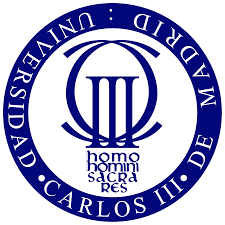


# PRÁCTICA 2.1: REDES DE NEURONAS
---

Autores: Pablo Hidalgo Delgado y Marcos Caballero Cortés   

NIAs: 100451225 y 100451047


## 1. Introducción.
El propósito de esta práctica es abordar un problema de clasificación clásico haciendo uso del Perceptrón Multicapa (PM).

Para ello, se nos dispone de un conjunto de datos desbalanceado sobre las trayectorias de diferentes individuos
en distintos medios de transporte.

Utilizando estos datos, debemos generar un modelo capaz de clasificar el medio de transporte en el que se desplaza un individuo.




## 2. Leer los conjuntos de datos


En primer lugar, importamos todas las librerías que se van a utilizar a lo largo de la práctica.

In [1]:
import random
import time
import pickle
import seaborn as sns


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import table

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Leemos el conjunto de datos proporcionado.

In [2]:
archivo_csv = 'dataRRNN2.csv'

datos = pd.DataFrame()

# Leemos el archivo
datos = pd.read_csv(archivo_csv)

## 3. Análisis Exploratorio de Datos (EDA)
Antes de empezar con la división en datos de entrenamiento y test, vamos a realizar un pequeño análisis exploratorio de datos (EDA). De esta manera, podremos investigar y resumir las características más importantes de nuestro dataset. Esto nos servirá para comprender mejor los datos y optimizar la obtención de nuestro modelo.


### 3.1 Información básica

In [3]:
datos.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29151 entries, 0 to 29150
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    29151 non-null  float64
 1   track_id                   29151 non-null  float64
 2   mean_delta_times           29151 non-null  float64
 3   std_delta_times            29151 non-null  float64
 4   mean_hours                 29151 non-null  float64
 5   std_hours                  29151 non-null  float64
 6   mean_distances             29151 non-null  float64
 7   std_distances              29151 non-null  float64
 8   mean_velocities            29151 non-null  float64
 9   std_velocities             29151 non-null  float64
 10  mean_accelerations         29151 non-null  float64
 11  std_accelerations          29151 non-null  float64
 12  mean_headings              29151 non-null  float64
 13  std_headings               29151 non-null  flo

El conjunto de datos se compone de 29151 instancias y 22 atributos de tipo float64. La variable de salida, label, es de tipo int64.

También podemos observar que no existen columnas que contengan valores nulos.

### 3.2 Atributos irrelevantes
En el apartado anterior identificamos las columnas user_id y track_id que parecen ser identificadores.


In [4]:
print(datos.head(5))

   user_id      track_id  mean_delta_times  std_delta_times  mean_hours  \
0     52.0  2.008071e+13          4.954975         0.304779         4.0   
1     52.0  2.008071e+13          4.890226         1.373293         4.0   
2    167.0  2.008081e+13          2.000000         0.000000         1.0   
3    167.0  2.008081e+13          2.000000         0.000000         1.0   
4    167.0  2.008081e+13          2.000000         0.000000         1.0   

   std_hours  mean_distances  std_distances  mean_velocities  std_velocities  \
0        0.0        7.370991       2.830568         1.475115        0.564191   
1        0.0        4.358587       3.252789         0.833067        0.604174   
2        0.0        2.298434       1.164979         1.149217        0.582489   
3        0.0        2.135659       0.579179         1.067830        0.289589   
4        0.0        0.321824       0.596578         0.160912        0.298289   

   ...  std_headings  mean_heading_changes  std_heading_changes  \
0

Los identificadores no aportan información predictiva para el modelo.

Por esta razón, eliminamos este atributo de nuestro conjunto de datos sin que exista riesgo de fuga de información.

In [5]:
datos.drop(['user_id', 'track_id'], axis=1, inplace=True)

### 3.2 Atributos compuestos de valores constantes

A continuación, vamos a analizar si existen columnas constantes en nuestro conjunto de datos. En ese caso, podremos eliminarlas de nuestro dataset ya que no aportan ninguna información a la variable de respuesta y no existe riesgo de information leakage.

In [6]:
# Eliminamos las columnas con solo un valor único
columnas_constantes = []
for col in datos.columns:
    if datos[col].nunique() == 1:
        print(col)
        columnas_constantes.append(col)
if len(columnas_constantes) == 0:
  print("No existen atributos con valores constantes")

No existen atributos con valores constantes


### 3.3 Distribución de clases
Aunque el enunciado ya indica que los datos presentan desbalanceo, es fundamental confirmar esta característica, así como observar y analizar la distribución de las clases.

0    10899
1     5543
2     6558
3     4403
4     1748
Name: label, dtype: int64


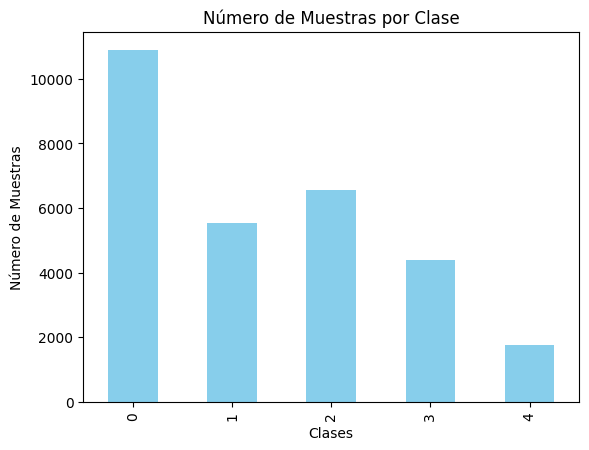

In [7]:
# Calculamos el recuento de muestras por clase y ordenamos por índice (las clases)
conteo_clases = datos['label'].value_counts().sort_index()

# Creamos la gráfica de barras
conteo_clases.plot(kind='bar', color='skyblue')
print(conteo_clases)
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Número de Muestras por Clase')
plt.show()

Vemos el claro desbalanceo de los datos teniendo la clase 0 (andando) bastante más muestras que las demás, en especial que la clase 4 (en metro).

## 5. Preproceso
Previamente a entrenar los modelos, debemos realizar una transformación de los datos para que puedan ser interpretados por el algoritmo de manera eficiente. Las transformaciones de datos que realizamos son las siguientes:

### 5.1 División de datos en train, validation y test.
Una vez explorado y analizado nuestro conjunto de datos, dividimos el dataset en conjuntos de entrenamiento (train), prueba (test) y validación (validation). Para ello, utilizamos la función train_test_split de la librería sklearn.

Dividimos los datos en 2/3 para train y 1/3 para test. El conjunto de validación se corresponderá con un 20% del conjunto de entrenamiento tal y como se nos pide en el enunciado de la práctica.

Antes de realizar la división, debemos separar la variable de respuesta del resto del conjunto de datos.

In [8]:
X = datos.drop("label", axis = 1)
y = datos["label"]

Dividimos el conjunto de datos. Lo hacemos especificando el parámetro suffle = True para que se aleatorizen los datos.

Además, al tratarse de un problema desbalanceado, utilizamos el parámetro stratify para realizar una partición estratificada, es decir, mantener la misma proporción de clases en ambos conjuntos.

También especificamos la semilla random_state a 40 para que los resultados sean reproducibles.



In [9]:
# Dividimos los datos originales en conjuntos de entrenamiento (2/3) y prueba (1/3%)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=1/3, random_state=40, shuffle = True, stratify=y)

# Dividimos el conjunto de entrenamiento en conjuntos de entrenamiento (80%) y validación (20%)
X_train_raw, X_validation_raw, y_train_raw, y_validation_raw = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=40, shuffle = True, stratify=y_train_raw)

# Guardamos los conjuntos de datos en archivos CSV
X_train_raw.to_csv('X_train_raw.csv', index=False)
y_train_raw.to_csv('y_train_raw.csv', index=False)
X_validation_raw.to_csv('X_validation_raw.csv', index=False)
y_validation_raw.to_csv('y_validation_raw.csv', index=False)
X_test_raw.to_csv('X_test_raw.csv', index=False)
y_test_raw.to_csv('y_test_raw.csv', index=False)

Verificamos que existen muestras de cada clase en cada conjunto de datos. Se deberá obtener la misma proporción que se obtuvo con el conjunto de datos entero.

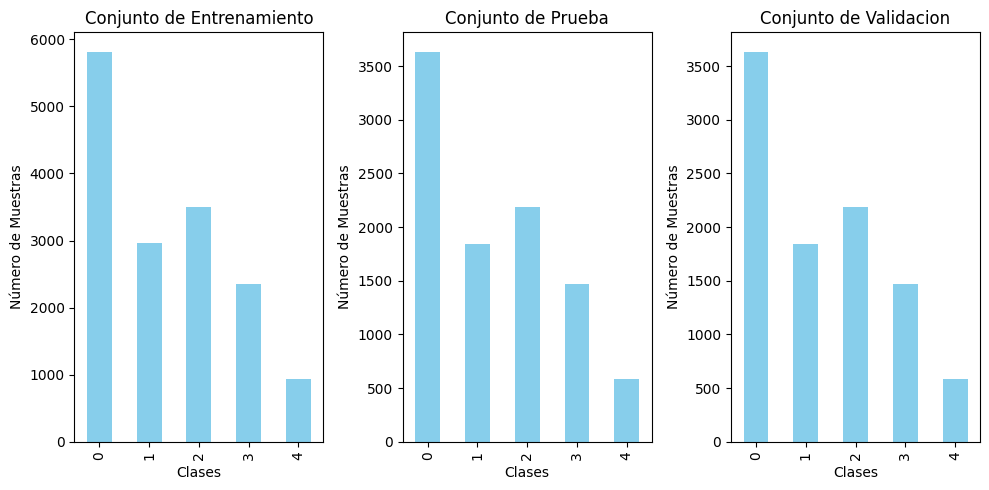

In [10]:
# Verificamos el balance de clases en los conjuntos de entrenamiento, prueba y validación
conteo_clases_train = y_train_raw.value_counts().sort_index()
conteo_clases_test = y_test_raw.value_counts().sort_index()
conteo_clases_validation = y_validation_raw.value_counts().sort_index()

# Creamos la gráfica de barras para los conjuntos de entrenamiento y prueba
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
conteo_clases_train.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Entrenamiento')

plt.subplot(1, 3, 2)
conteo_clases_test.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Prueba')


plt.subplot(1, 3, 3)
conteo_clases_test.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Validacion')

plt.tight_layout()
plt.show()

### 5.2 Aleatorización
La aleatorización de los datos la hemos realizado al dividir el conjunto de datos en train, test y validation al especificar el parametro shuffle = True.

### 5.3 Codificación de la variable de salida
Al estar frente a un problema de clasificación multiclase (5 clases distintas) es importante codificar estos valores para asegurar la compatibilidad con el Perceptrón Multicapa. Para ello, utilizamos la clase LabelBinarizer de scikit learn.

In [11]:
print("Sin codificar:\n", y_train_raw, "\n")
# Binarizamos la variable de salida usando LabelBinarizer
label_binarizer = LabelBinarizer()

# Binarizamos y_train
y_train_binarized = label_binarizer.fit_transform(y_train_raw)

# Binarizamos y_validation
y_validation_binarized = label_binarizer.transform(y_validation_raw)

# Binarizamos y_test
y_test_binarized = label_binarizer.transform(y_test_raw)
print("Codificado: \n", y_train_binarized)

Sin codificar:
 25688    0
22960    0
12721    3
4071     1
708      2
        ..
1535     0
20962    0
10501    3
27156    2
4968     3
Name: label, Length: 15547, dtype: int64 

Codificado: 
 [[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 ...
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]]


### 5.4 Normalización
Para que no se produzca information leakage y no dar información al conjunto de test, normalizamos todos los datos con el mínimo y máximo obtenido del conjunto de entrenamiento.

In [12]:
X_train = X_train_raw
X_validation = X_validation_raw
X_test = X_test_raw

# Normalizamos X
for columna in X_train_raw:
 # Obtenemos el minimo y el maximo de cada columna del conjunto de train
  min = X_train_raw[columna].min()
  max = X_train_raw[columna].max()
  # Conjunto de entrenamiento
  X_train[columna] = (X_train_raw[columna] - min)/(max - min)
  # Conjunto de validación
  X_validation[columna] = (X_validation_raw[columna] - min)/(max - min)
  # Conjunto de test
  X_test[columna] = (X_test_raw[columna] - min)/(max - min)

# Normalizamos y (en realidad no es necesario ya que al estar codificado en OHE solo habrá 0 y 1 y el resultado será el mismo)
y_min = y_train_binarized.min()
y_max = y_train_binarized.max()
# Conjunto de entrenamiento
y_train = (y_train_binarized - y_min)/(y_max - y_min)
# Conjunto de validación
y_validation = (y_validation_binarized - y_min)/(y_max - y_min)
# Conjunto de test
y_test = (y_test_binarized - y_min)/(y_max - y_min)

# Guardamos los conjuntos de datos en archivos CSV
X_train.to_csv('X_train.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
X_validation.to_csv('X_validation.csv', index=False)
pd.DataFrame(y_validation).to_csv('y_validation.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

## 6. Perceptrón Multicapa

### 6.1 Implementación

In [13]:
input_shape=(X_train.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla.

def build_and_train_mlp(learning_rate, num_hidden_layers, num_neurons, activation_function, epochs, patience=6, balance_classes=False):
    model = Sequential()

    # Capa de entrada
    model.add(Dense(num_neurons[0], activation=activation_function, input_shape=input_shape))

    # Capas ocultas
    for i in range(1, num_hidden_layers):
        model.add(Dense(num_neurons[i], activation=activation_function))

    # Capa de salida (5 clases --> 5 neuronas)
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0), metrics=['mse'])

    # Calculamos los pesos de clase para el balanceo si es necesario
    if balance_classes:
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_raw), y=y_train_raw) # Especificamos las clases sin codificarlas con el OHE
        class_weight_dict = dict(enumerate(class_weights))
    else:
        class_weight_dict = None

    # Definimos el criterio de parada Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True) # Especificamos la paciencia introducida como parámetro y que se restauren automáticamente los pesos a la mejor época

    start_time = time.time()
    # Entrenamos el modelo, incluyendo o no el balanceo de clases según el parámetro
    historico = model.fit(X_train, y_train, epochs=epochs, batch_size=32, callbacks=[early_stopping], validation_data=(X_validation, y_validation), class_weight=class_weight_dict, verbose=0)
    tiempo_total = time.time() - start_time
    print(f"Tiempo de entrenamiento para (lr = {learning_rate}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {tiempo_total}s")

    return model,historico

### 6.2 Experimentos realizados

Debemos elegir los mejores hiperparámetros para nuestro conjunto de datos. Para ello, construimos distintos modelos con diferentes configuraciones de hiperparámetros. Escogeremos los 3 modelos con la combinación de hiperparámetros cuyo MSE de validación sea el menor.

Cada uno de estos modelos tendrá el criterio de parada de Early Stopping, con una paciencia de 20 épocas. Por tanto, el aprendizaje del modelo se interrumpirá si, después de haber esperado pacientemente 20 épocas consecutivas, no se observa una mejora en la métrica de error cuadrático medio (MSE) en el conjunto de validación.


Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=relu): 311.7671060562134s
304/304 [==============================] - 0s 1ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=relu): 5.05e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 5.02e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


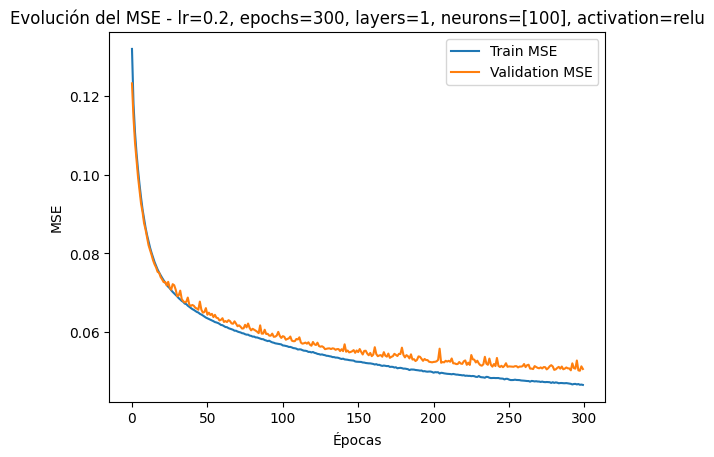

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=sigmoid): 320.2904784679413s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=sigmoid): 6.70e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 6.72e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


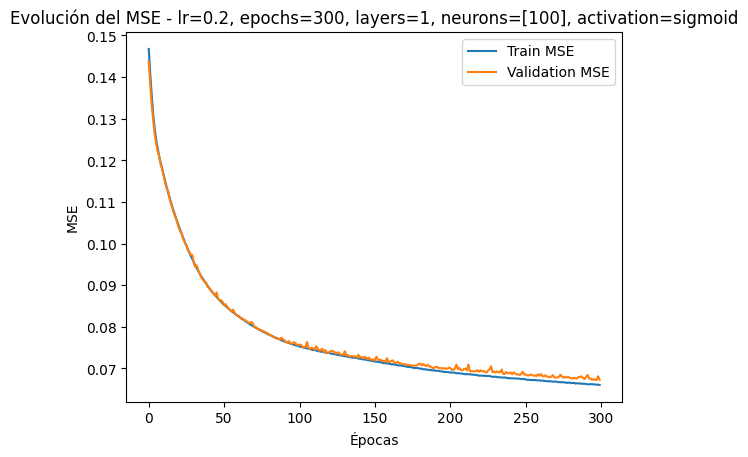

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=softmax): 304.2396607398987s
304/304 [==============================] - 0s 1ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=softmax): 8.37e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 8.40e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


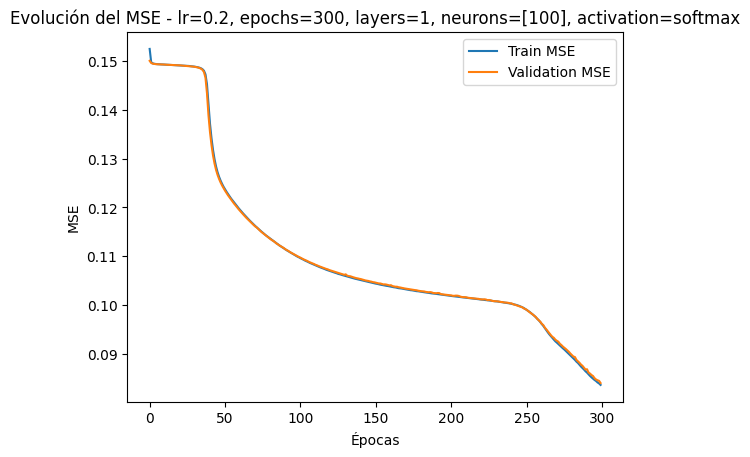

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=relu): 186.2103078365326s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=relu): 4.89e-02
Época con el menor MSE de validación: 166
MSE de validación mínimo: 4.94e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


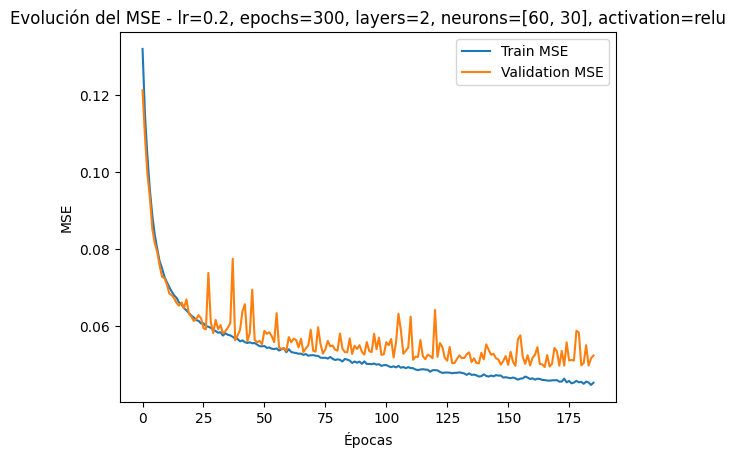

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=sigmoid): 316.1555404663086s
304/304 [==============================] - 0s 1ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=sigmoid): 5.96e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 6.03e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


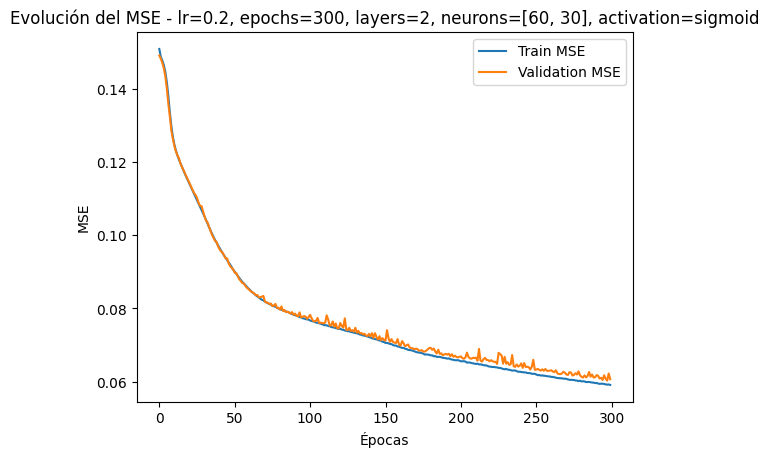

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=softmax): 322.43810272216797s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 297
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


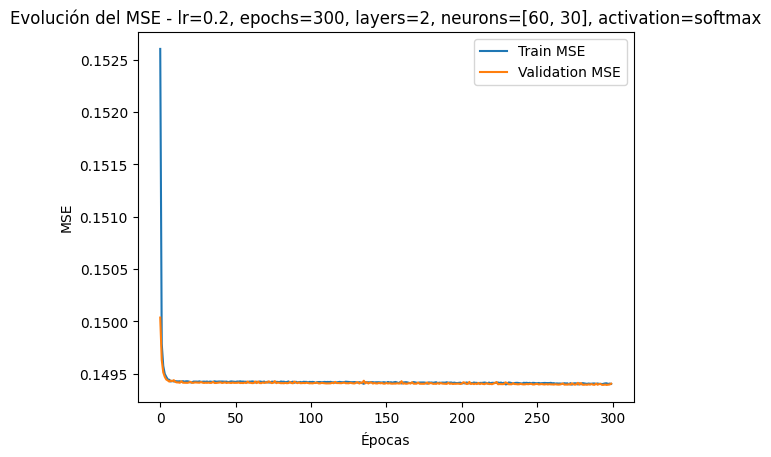

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=relu): 112.03778839111328s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=relu): 5.01e-02
Época con el menor MSE de validación: 85
MSE de validación mínimo: 5.01e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


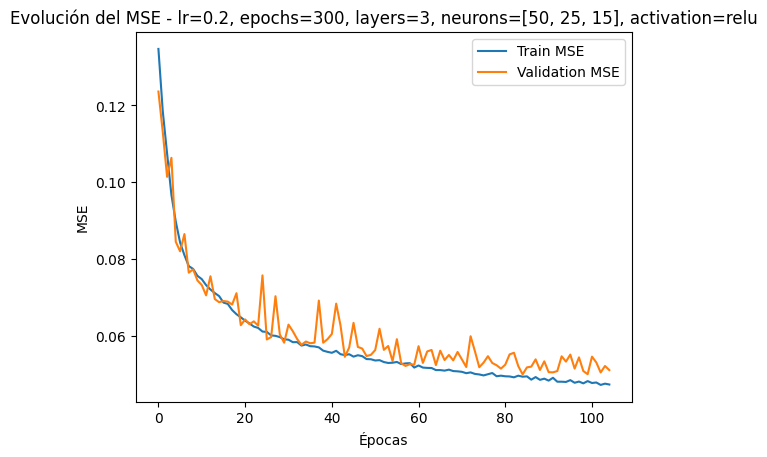

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=sigmoid): 324.37268352508545s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=sigmoid): 6.29e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 6.38e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


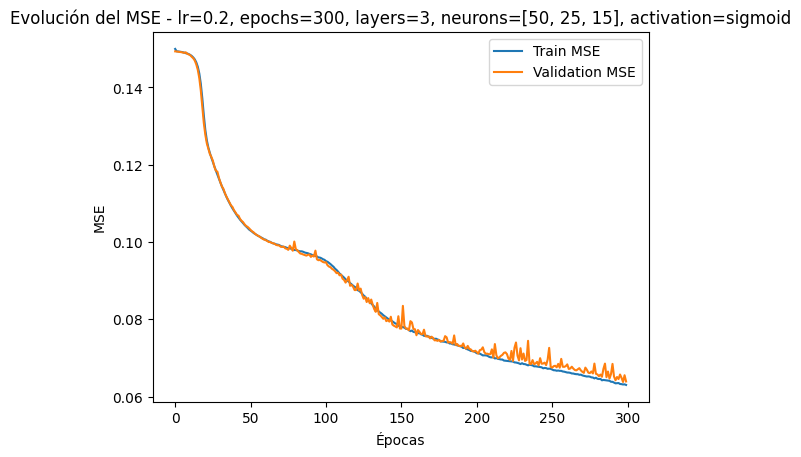

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=softmax): 65.0146472454071s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 38
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


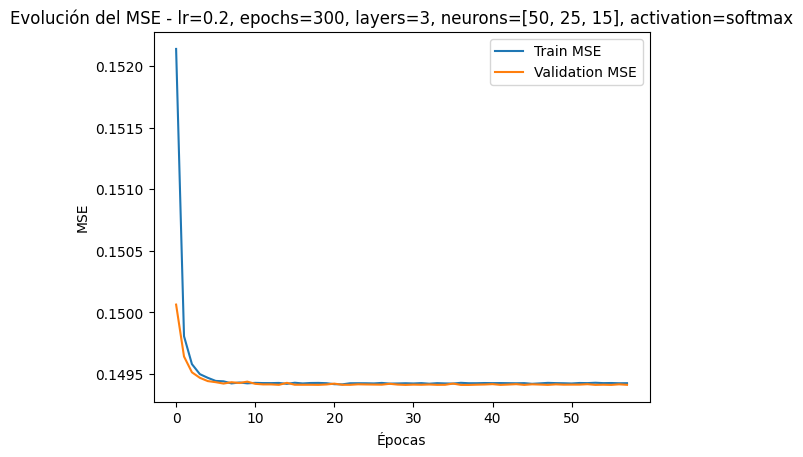

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=relu): 304.8517150878906s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=relu): 5.00e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 4.93e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


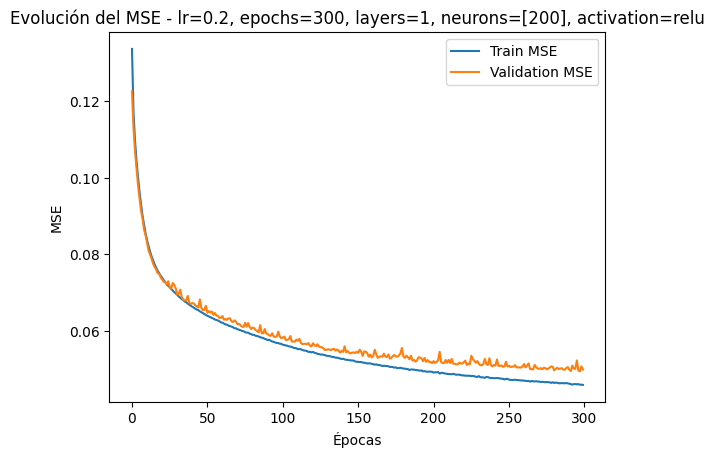

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=sigmoid): 322.3783724308014s
304/304 [==============================] - 1s 1ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=sigmoid): 6.71e-02
Época con el menor MSE de validación: 295
MSE de validación mínimo: 6.73e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


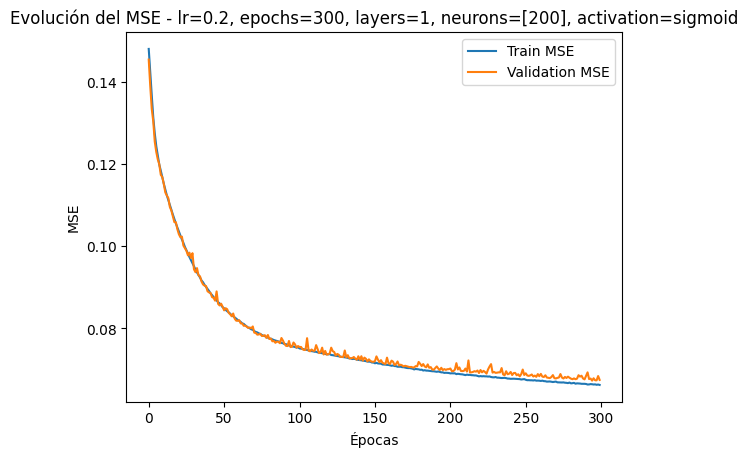

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=softmax): 314.97854709625244s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=softmax): 1.02e-01
Época con el menor MSE de validación: 299
MSE de validación mínimo: 1.02e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


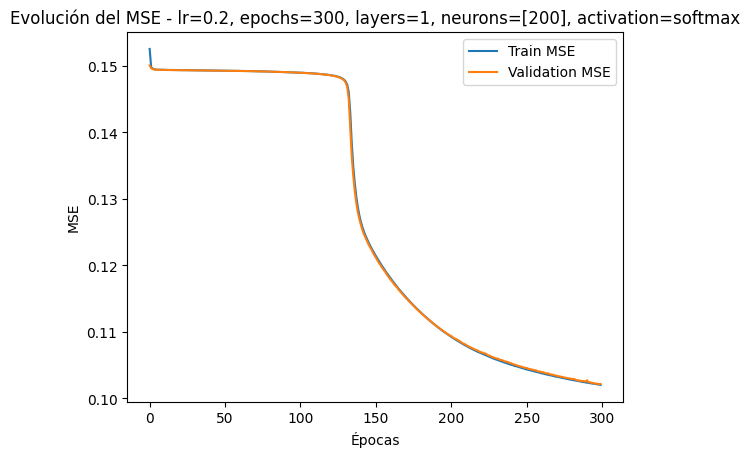

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=relu): 190.31310749053955s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=relu): 4.74e-02
Época con el menor MSE de validación: 148
MSE de validación mínimo: 4.73e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


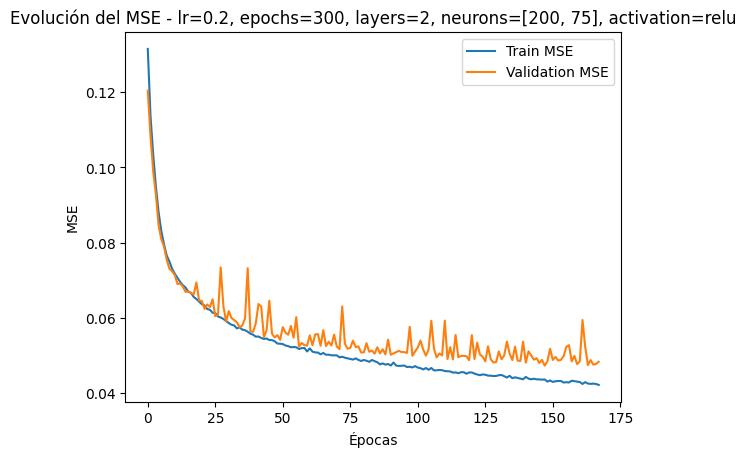

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=sigmoid): 338.0387020111084s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=sigmoid): 6.16e-02
Época con el menor MSE de validación: 295
MSE de validación mínimo: 6.22e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


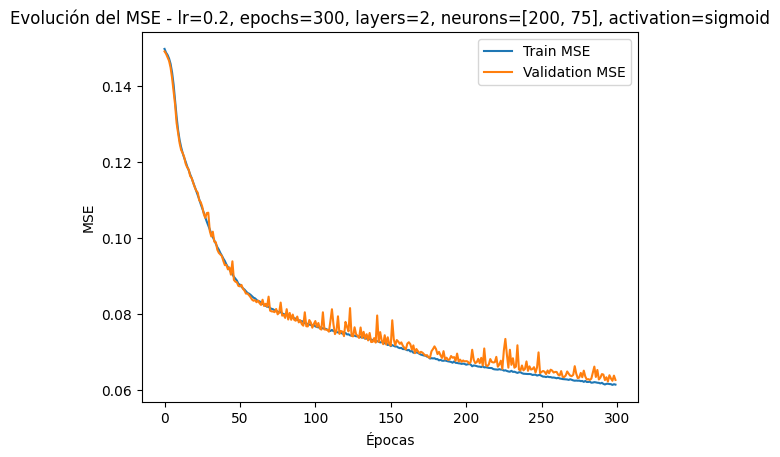

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=softmax): 67.5189049243927s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 38
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


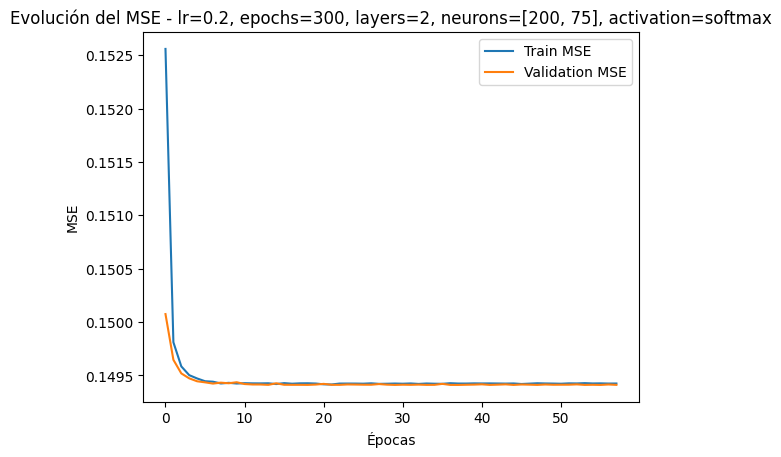

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 176.80901789665222s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 4.66e-02
Época con el menor MSE de validación: 130
MSE de validación mínimo: 4.61e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


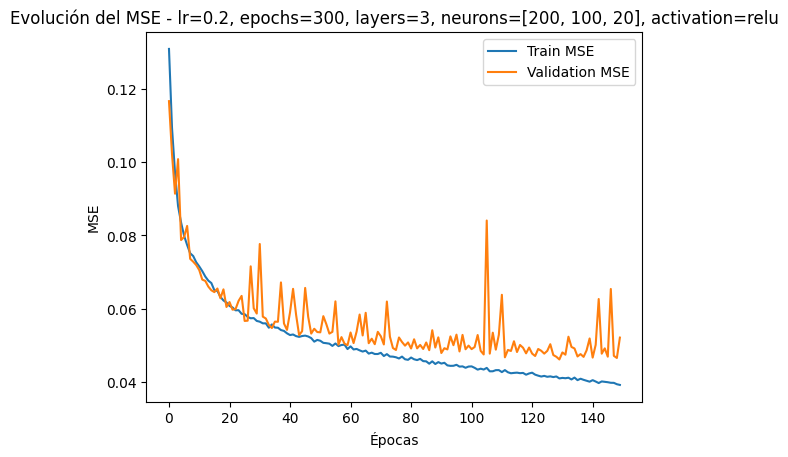

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=sigmoid): 350.46120595932007s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=sigmoid): 6.38e-02
Época con el menor MSE de validación: 287
MSE de validación mínimo: 6.39e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


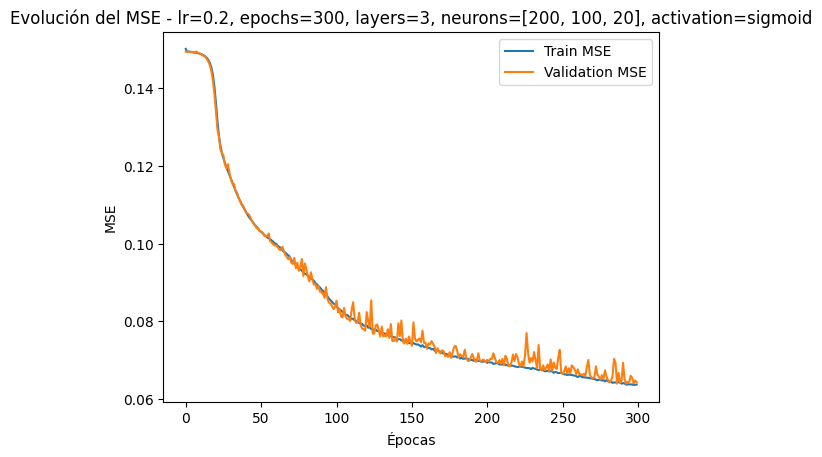

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=softmax): 69.90950846672058s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 38
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


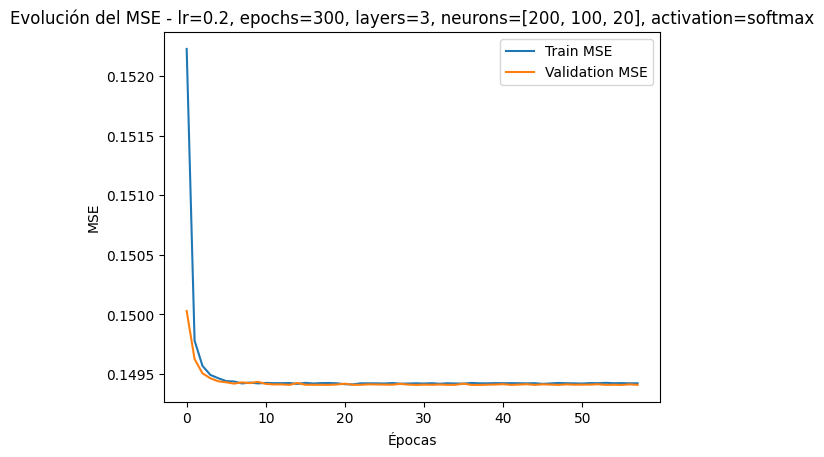

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 322.3575577735901s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 5.01e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 4.97e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


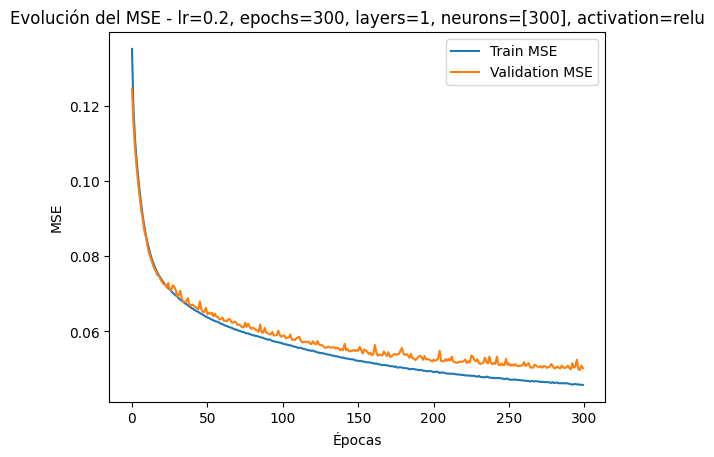

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 318.0565986633301s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 6.74e-02
Época con el menor MSE de validación: 295
MSE de validación mínimo: 6.74e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


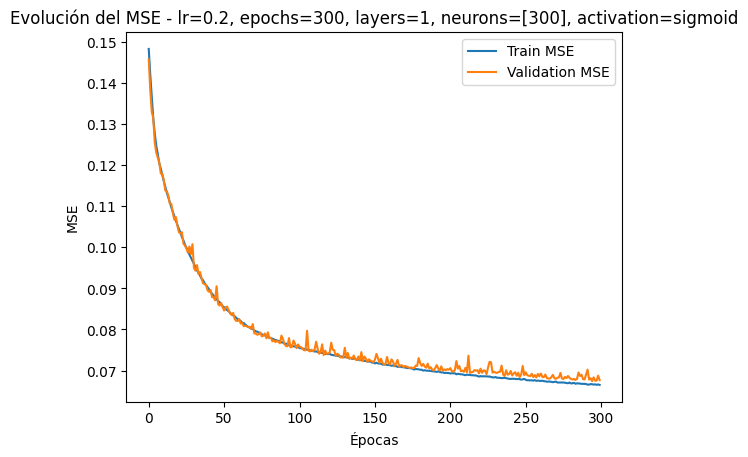

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 329.18563771247864s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 1.07e-01
Época con el menor MSE de validación: 300
MSE de validación mínimo: 1.07e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


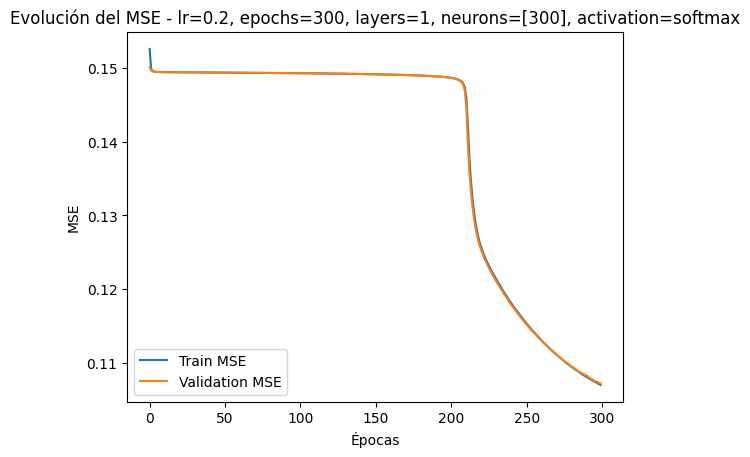

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 128.80153369903564s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 4.96e-02
Época con el menor MSE de validación: 91
MSE de validación mínimo: 4.97e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


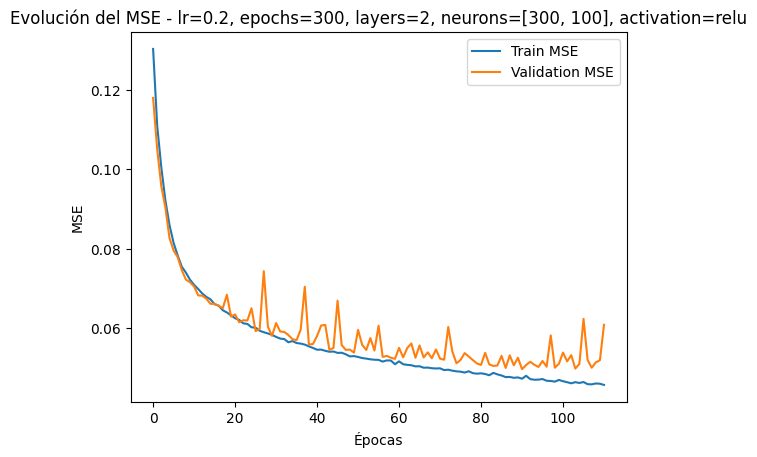

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 354.7841236591339s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 6.15e-02
Época con el menor MSE de validación: 295
MSE de validación mínimo: 6.23e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


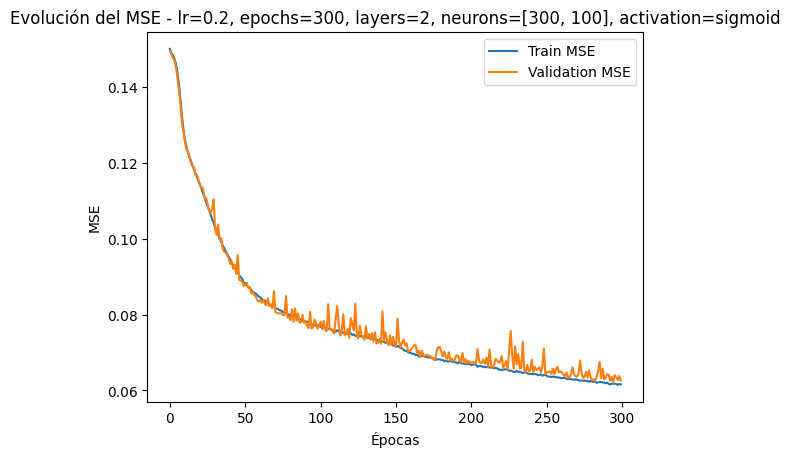

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 70.94667887687683s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 38
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


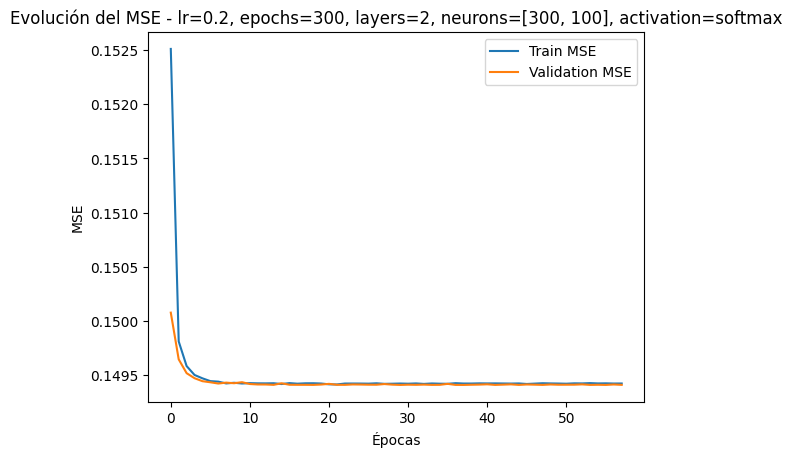

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 209.2060227394104s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.64e-02
Época con el menor MSE de validación: 130
MSE de validación mínimo: 4.56e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


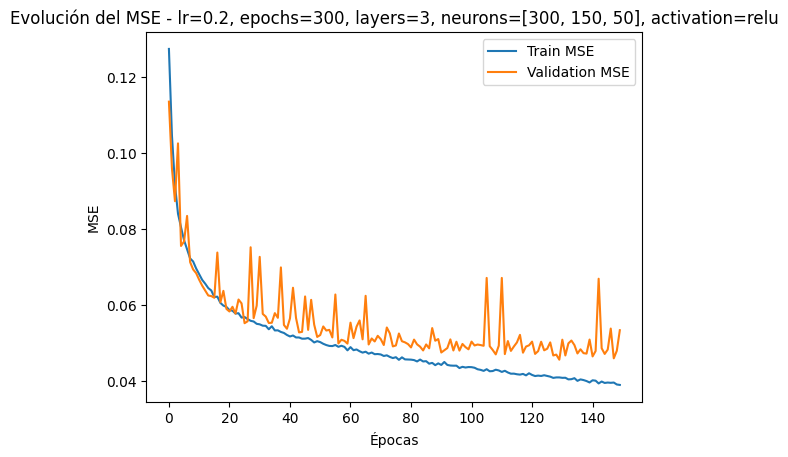

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 414.3206961154938s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 6.42e-02
Época con el menor MSE de validación: 287
MSE de validación mínimo: 6.44e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


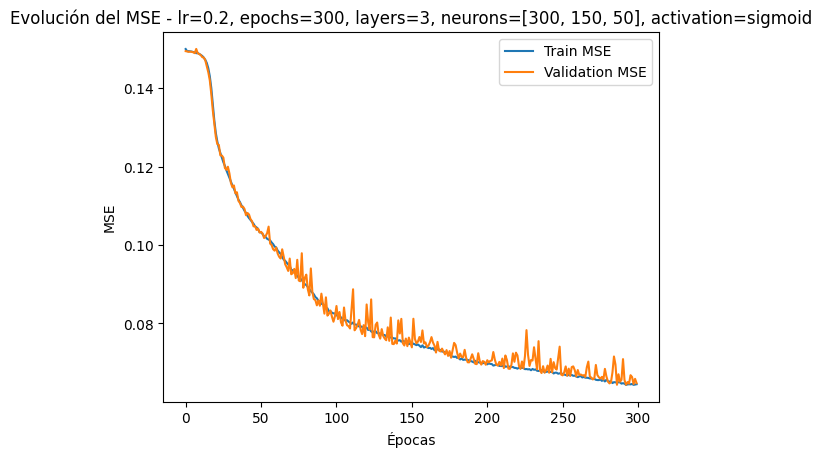

Tiempo de entrenamiento para (lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 87.05163669586182s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 38
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


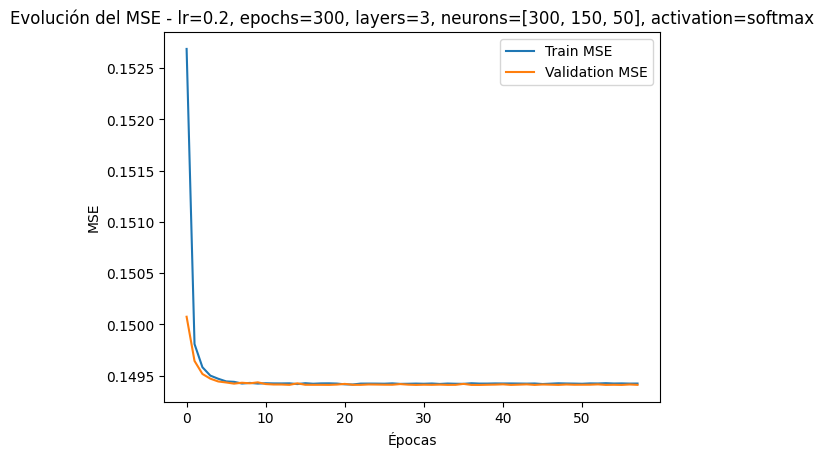

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=relu): 322.37634897232056s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=relu): 5.45e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 5.47e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


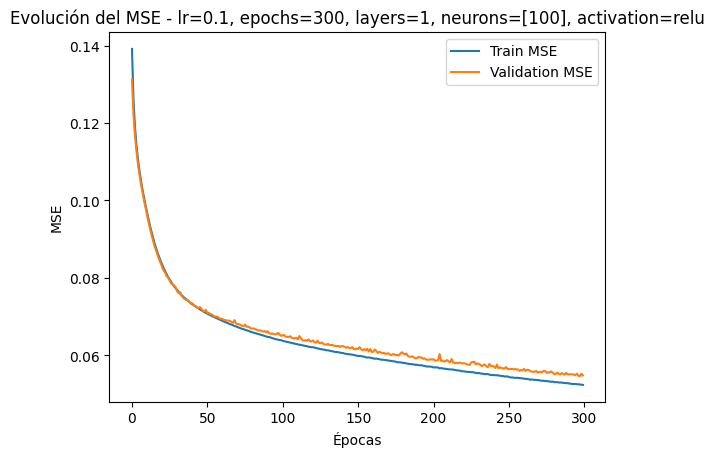

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=sigmoid): 297.26591062545776s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=sigmoid): 7.18e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 7.16e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


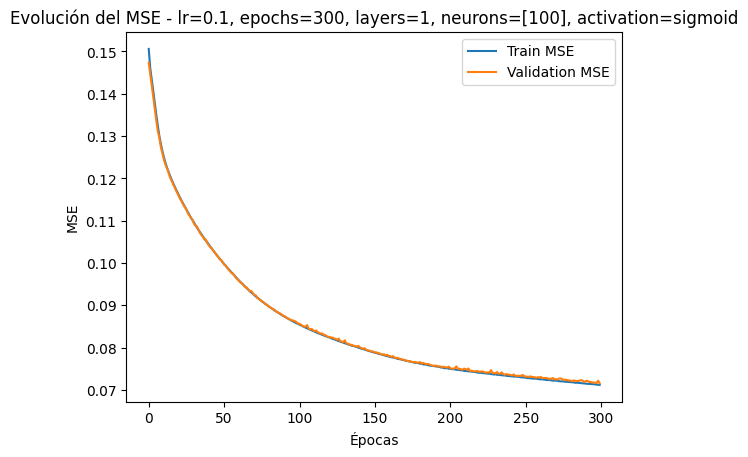

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=softmax): 310.3083348274231s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=softmax): 1.02e-01
Época con el menor MSE de validación: 299
MSE de validación mínimo: 1.02e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


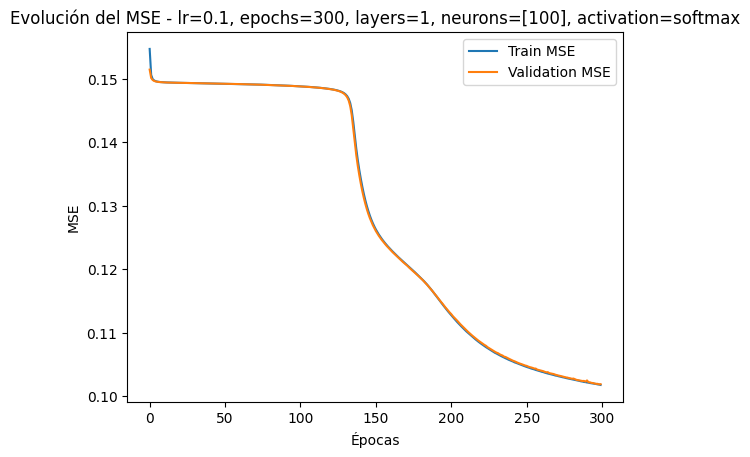

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=relu): 249.36749935150146s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=relu): 4.98e-02
Época con el menor MSE de validación: 217
MSE de validación mínimo: 4.96e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


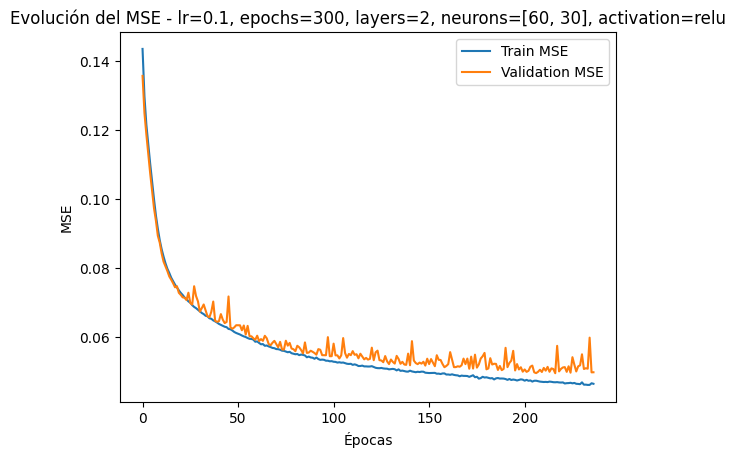

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=sigmoid): 322.4373667240143s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=sigmoid): 7.15e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 7.15e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


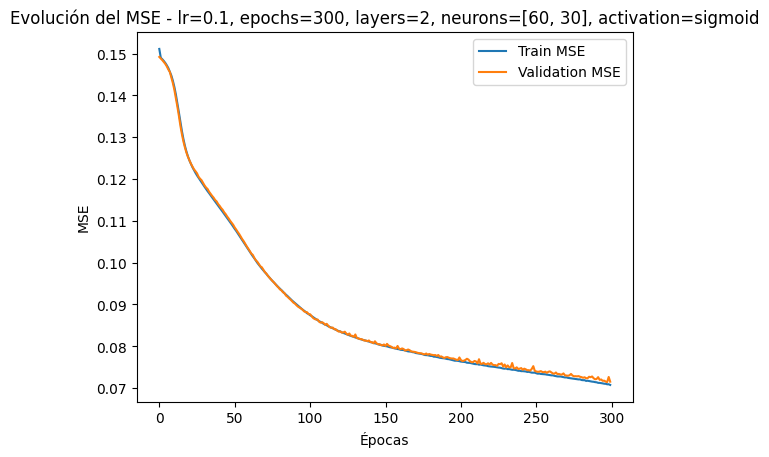

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=softmax): 322.43769788742065s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 289
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


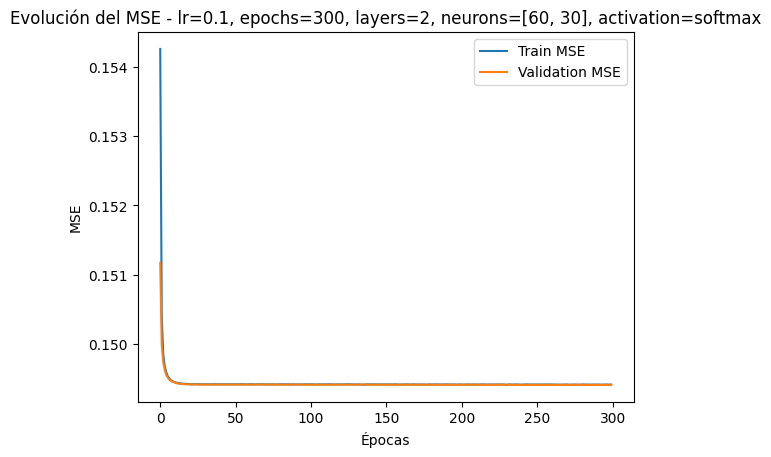

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=relu): 109.83182096481323s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=relu): 5.15e-02
Época con el menor MSE de validación: 84
MSE de validación mínimo: 5.25e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


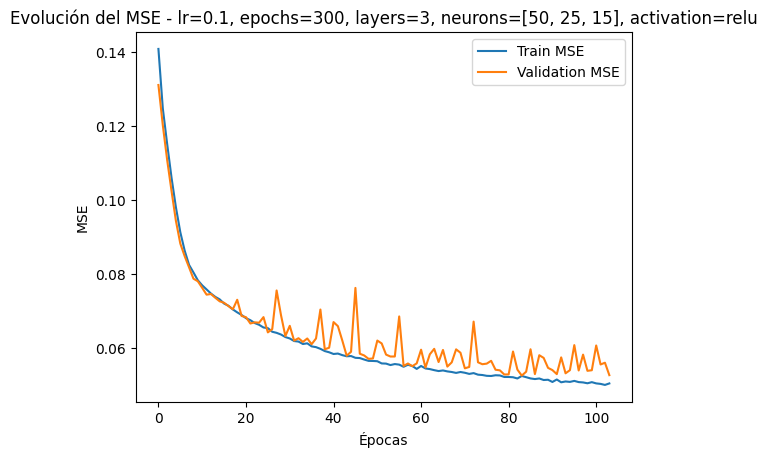

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=sigmoid): 322.52239441871643s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=sigmoid): 7.45e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 7.47e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


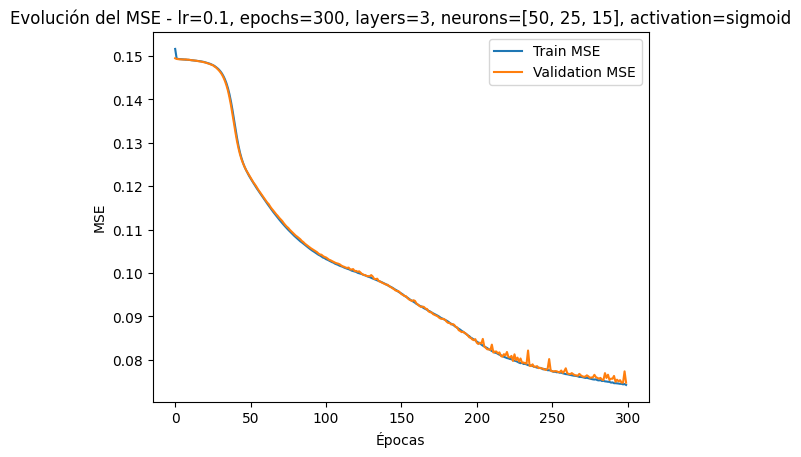

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=softmax): 82.93497633934021s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 54
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


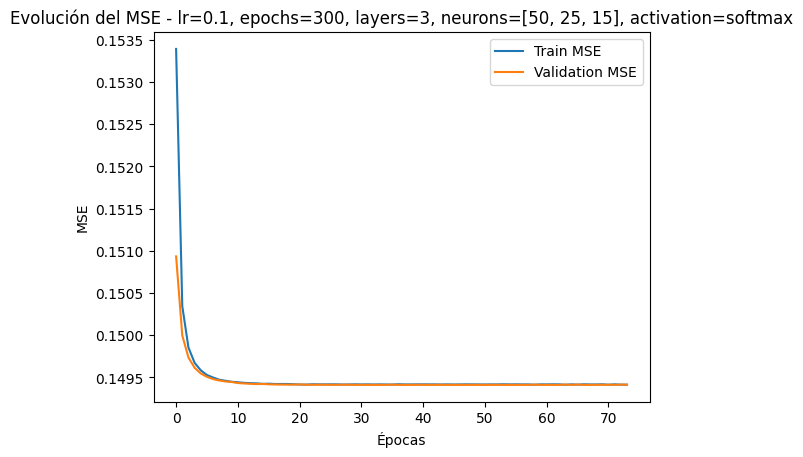

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=relu): 301.82179856300354s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=relu): 5.41e-02
Época con el menor MSE de validación: 297
MSE de validación mínimo: 5.40e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


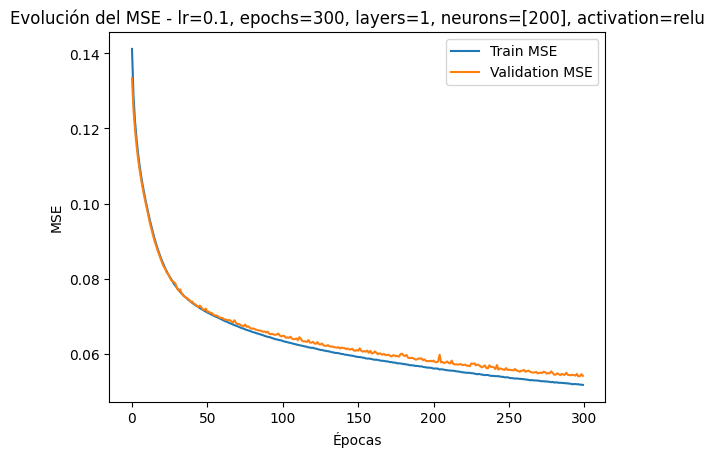

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=sigmoid): 322.37116718292236s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=sigmoid): 7.21e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 7.19e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


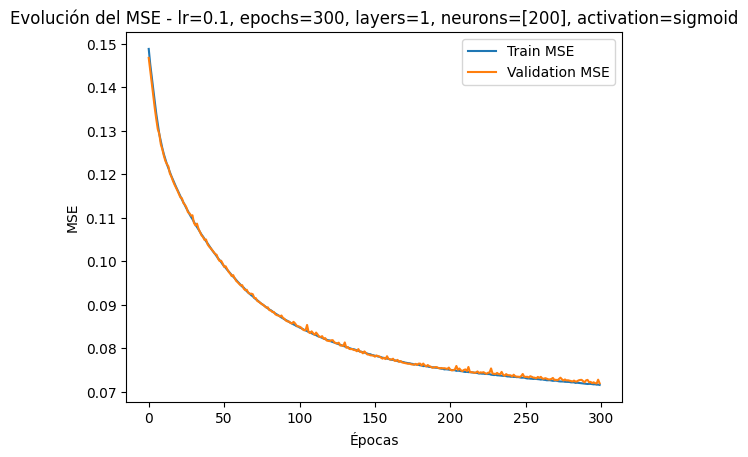

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=softmax): 322.37117552757263s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=softmax): 1.19e-01
Época con el menor MSE de validación: 300
MSE de validación mínimo: 1.19e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


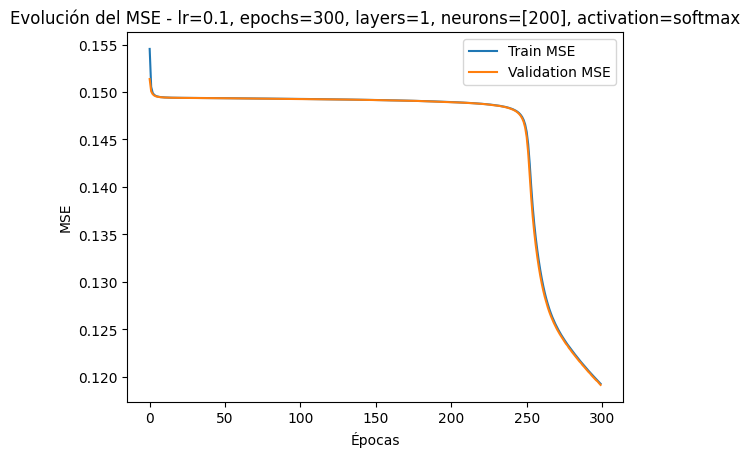

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=relu): 264.69320130348206s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=relu): 4.85e-02
Época con el menor MSE de validación: 217
MSE de validación mínimo: 4.84e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


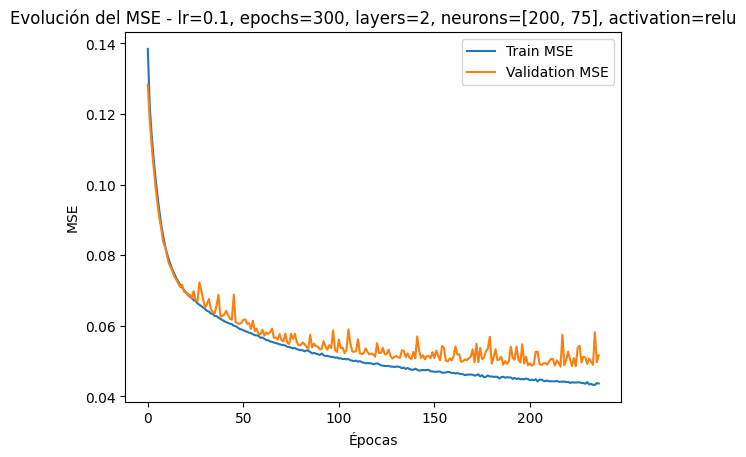

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=sigmoid): 346.82598090171814s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=sigmoid): 7.05e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 7.01e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


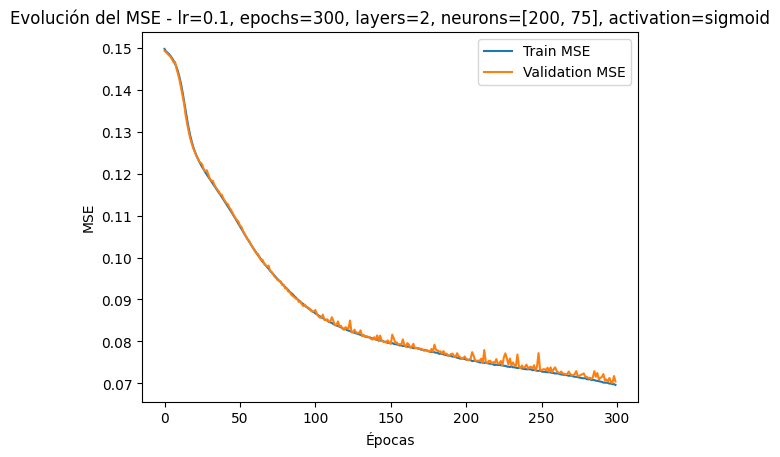

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=softmax): 84.24401259422302s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 54
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


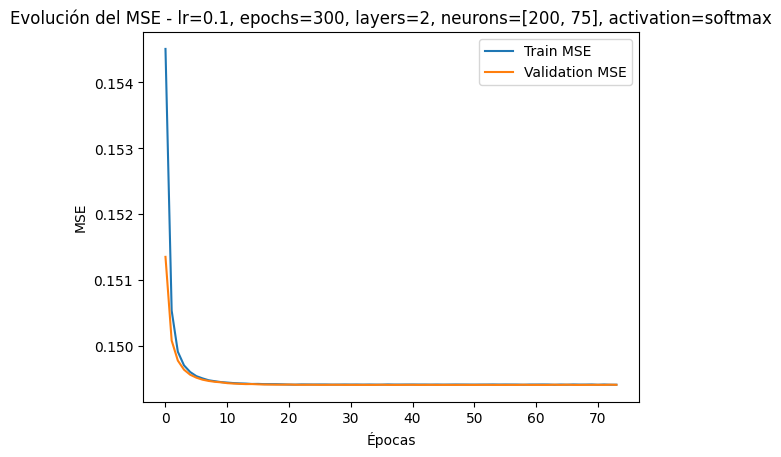

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 179.23367476463318s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 4.72e-02
Época con el menor MSE de validación: 139
MSE de validación mínimo: 4.73e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


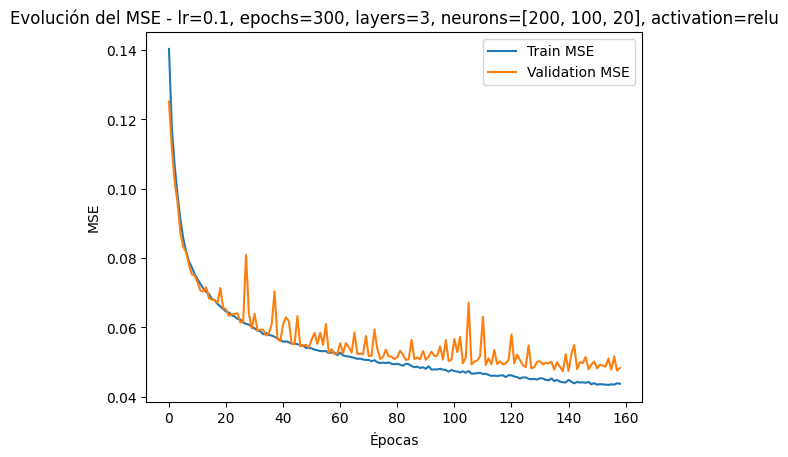

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=sigmoid): 382.51322317123413s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=sigmoid): 7.34e-02
Época con el menor MSE de validación: 293
MSE de validación mínimo: 7.31e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


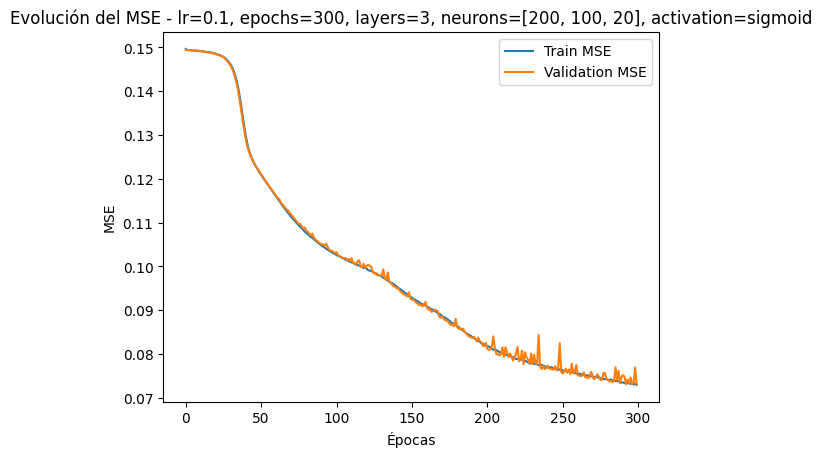

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=softmax): 98.96951365470886s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 65
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


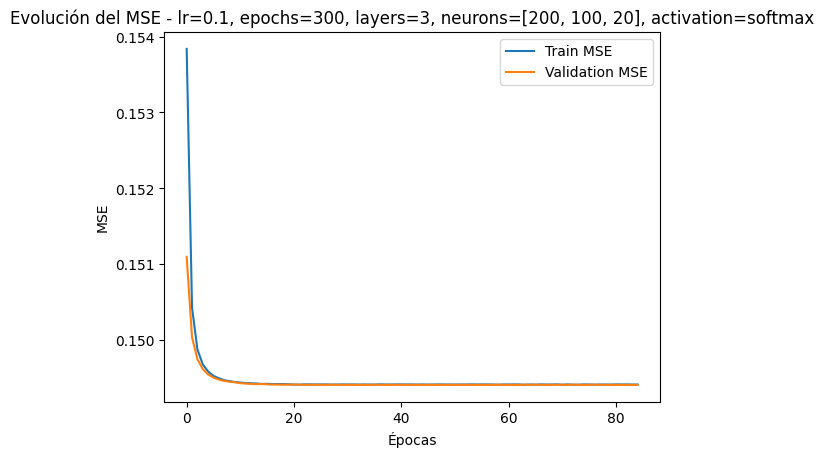

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 303.9312243461609s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 5.38e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 5.40e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


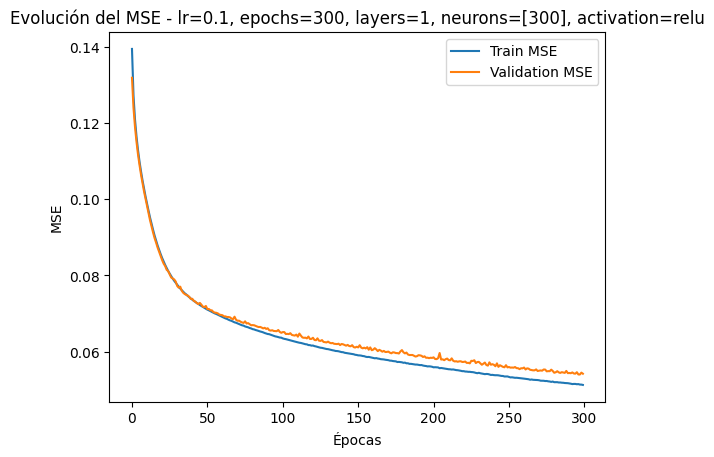

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 306.0005226135254s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 7.19e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 7.17e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


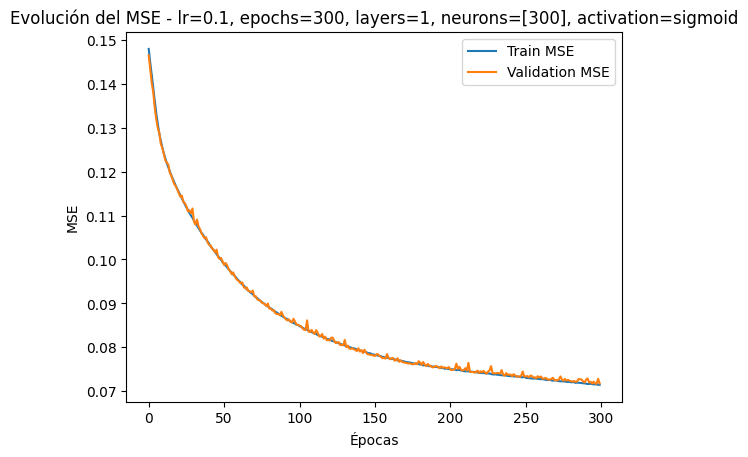

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 307.8958189487457s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 300
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


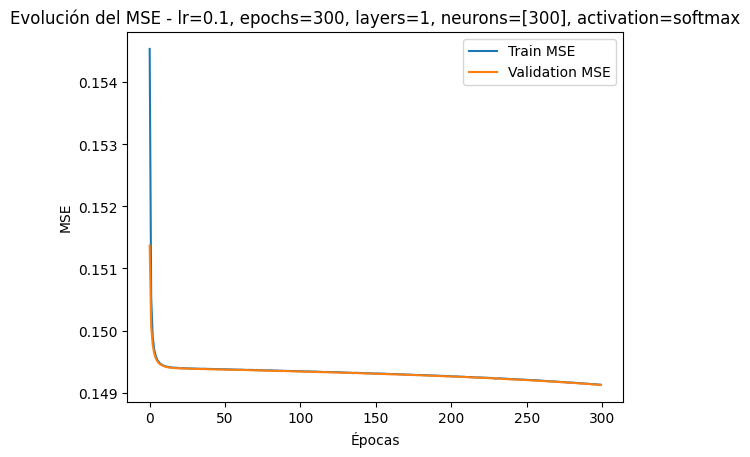

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 245.32714700698853s
304/304 [==============================] - 1s 3ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 4.84e-02
Época con el menor MSE de validación: 202
MSE de validación mínimo: 4.85e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


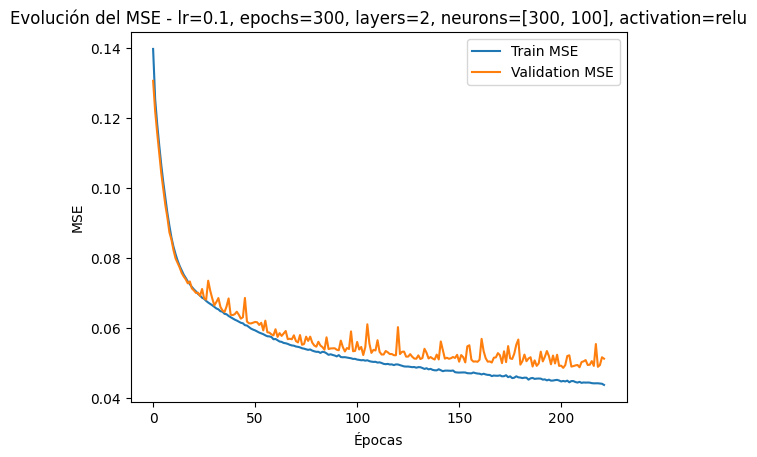

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 382.69855260849s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 7.24e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 7.17e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


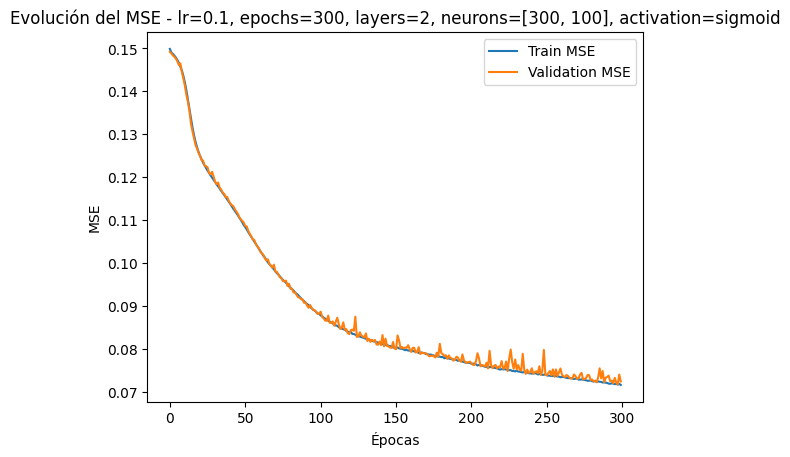

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 86.0798659324646s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 56
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


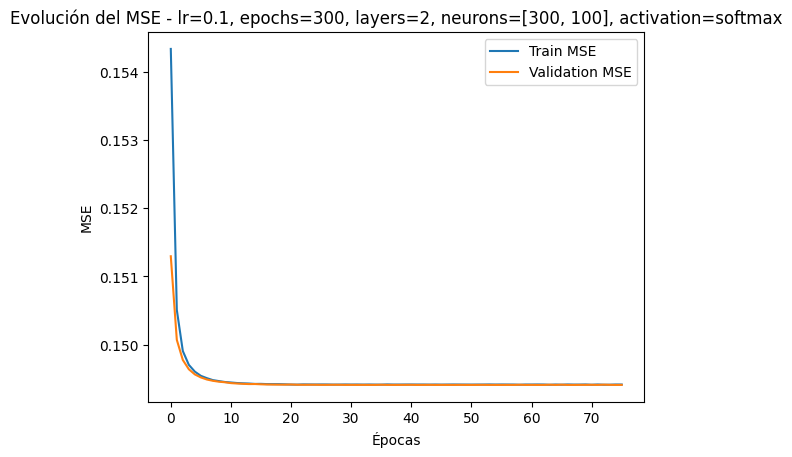

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 202.0560221672058s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.79e-02
Época con el menor MSE de validación: 139
MSE de validación mínimo: 4.85e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


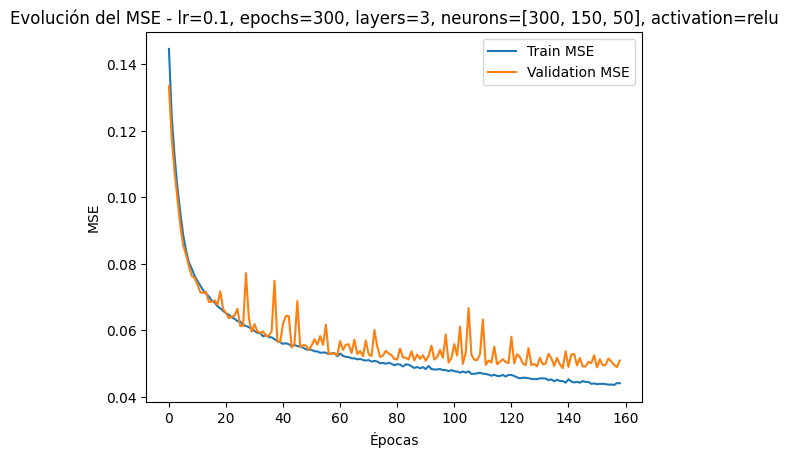

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 388.9209442138672s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 7.46e-02
Época con el menor MSE de validación: 289
MSE de validación mínimo: 7.37e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


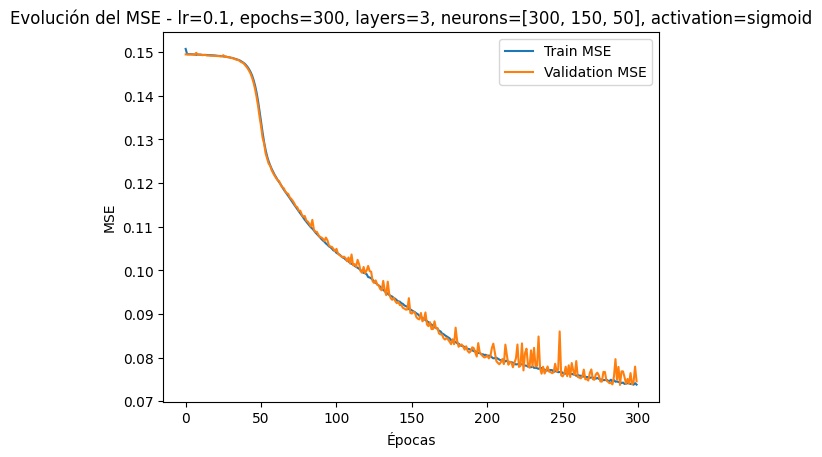

Tiempo de entrenamiento para (lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 104.08524179458618s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 56
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


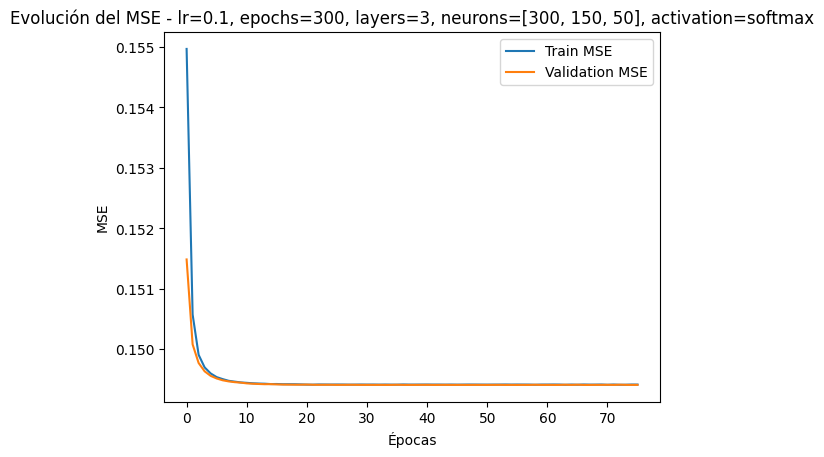

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=relu): 323.0570652484894s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=relu): 6.13e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 6.13e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


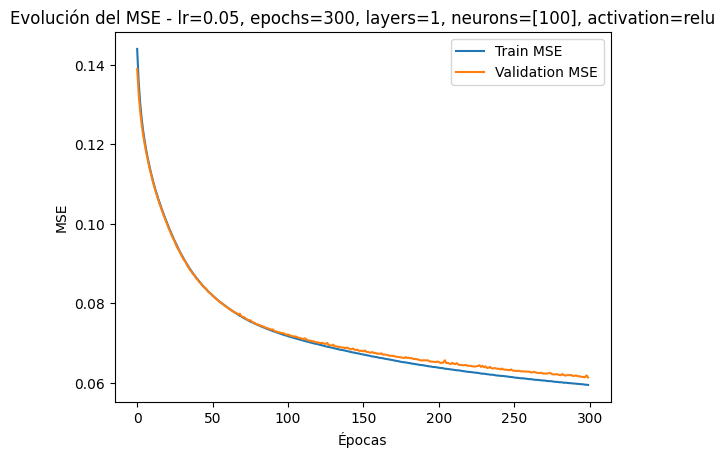

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=sigmoid): 295.55806255340576s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=sigmoid): 7.89e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 7.86e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


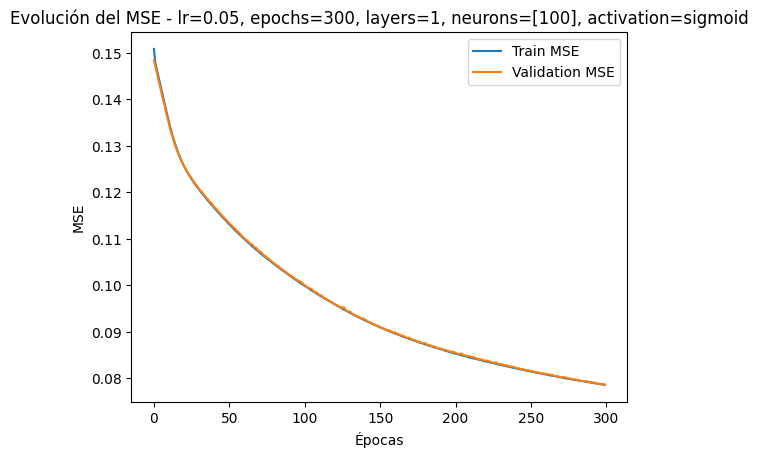

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=softmax): 298.0353503227234s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[100], activation_function=softmax): 1.17e-01
Época con el menor MSE de validación: 300
MSE de validación mínimo: 1.17e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


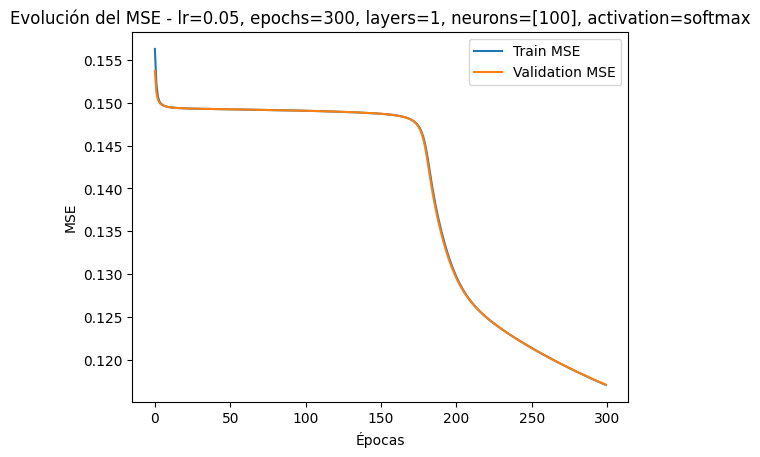

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=relu): 302.1689417362213s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=relu): 5.12e-02
Época con el menor MSE de validación: 292
MSE de validación mínimo: 5.11e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


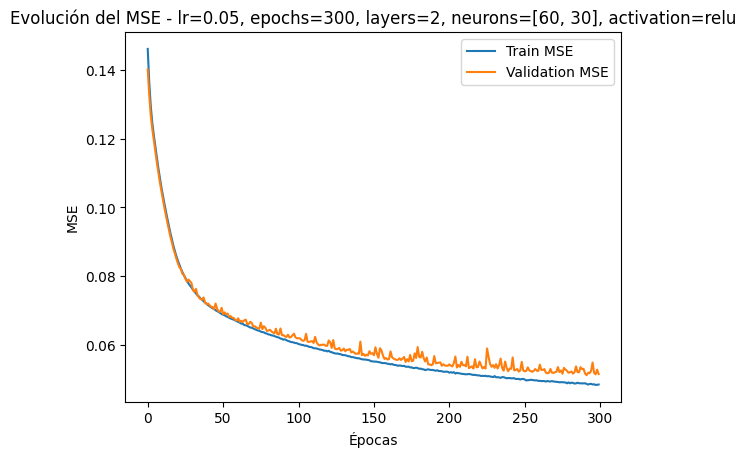

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=sigmoid): 307.1030604839325s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=sigmoid): 8.06e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 8.03e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


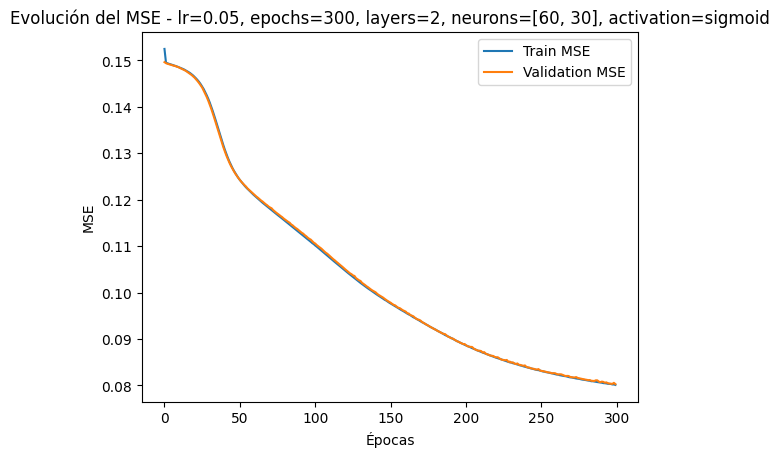

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=softmax): 322.4546527862549s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[60, 30], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 298
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


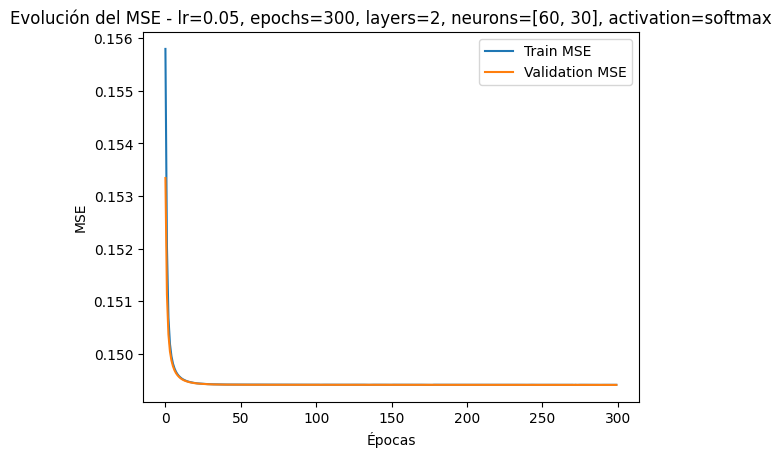

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=relu): 251.44233512878418s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=relu): 5.11e-02
Época con el menor MSE de validación: 225
MSE de validación mínimo: 5.16e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


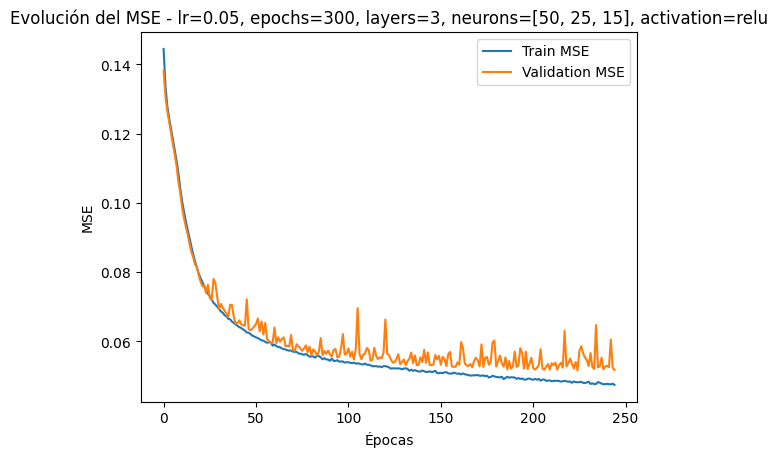

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=sigmoid): 322.47428822517395s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=sigmoid): 9.81e-02
Época con el menor MSE de validación: 299
MSE de validación mínimo: 9.83e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


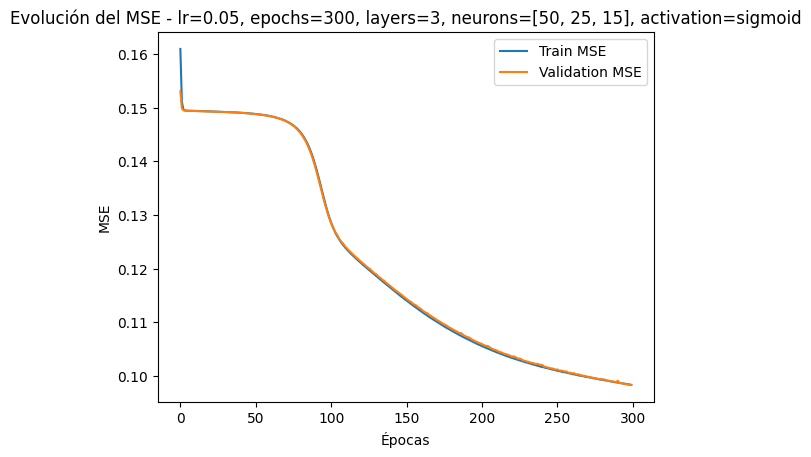

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=softmax): 145.94485211372375s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[50, 25, 15], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 116
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


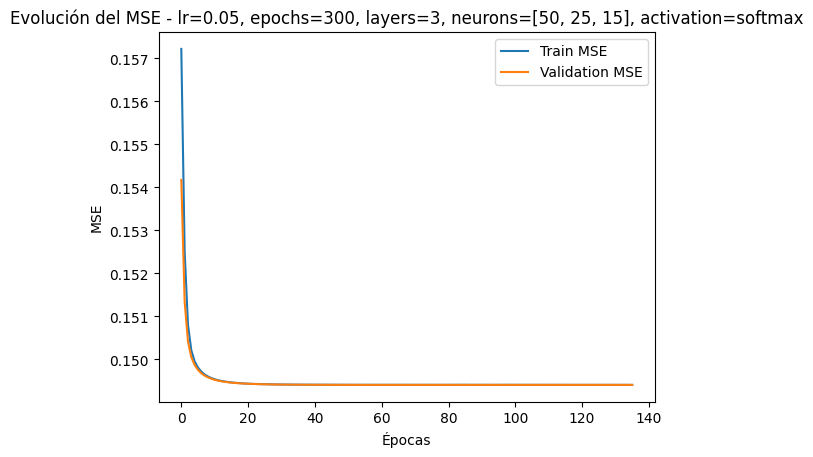

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=relu): 322.3670358657837s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=relu): 6.05e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 6.06e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


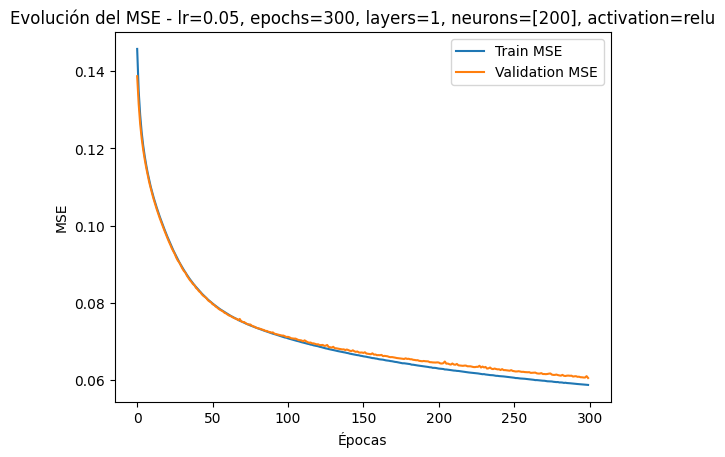

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=sigmoid): 322.35612440109253s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=sigmoid): 7.88e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 7.86e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


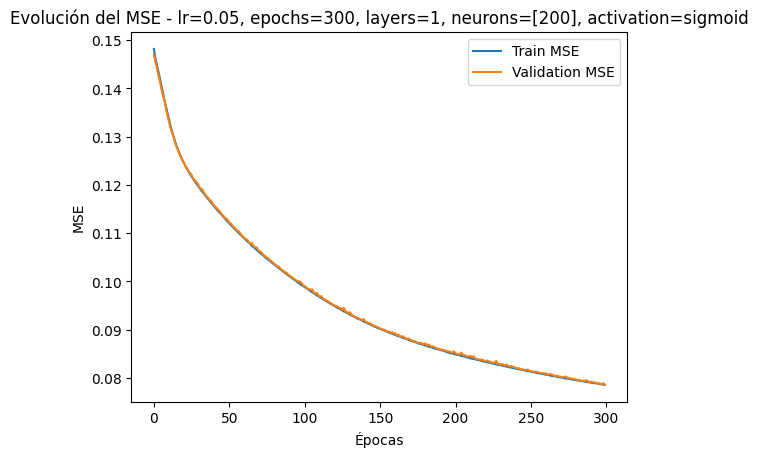

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=softmax): 302.1026520729065s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[200], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 300
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


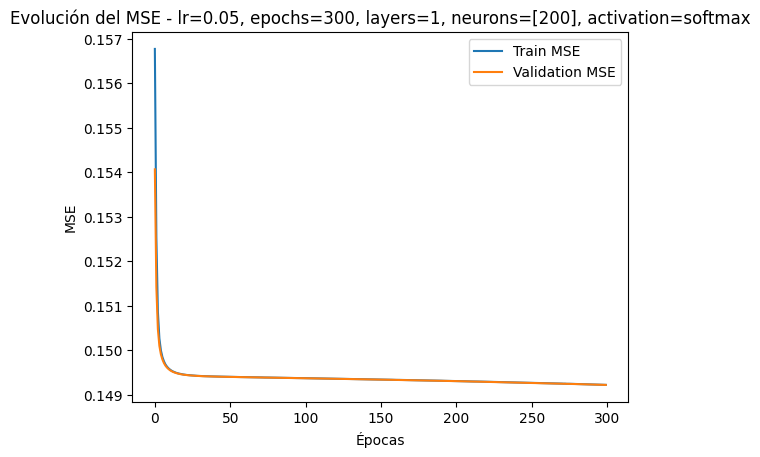

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=relu): 254.48537230491638s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=relu): 5.13e-02
Época con el menor MSE de validación: 217
MSE de validación mínimo: 5.11e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


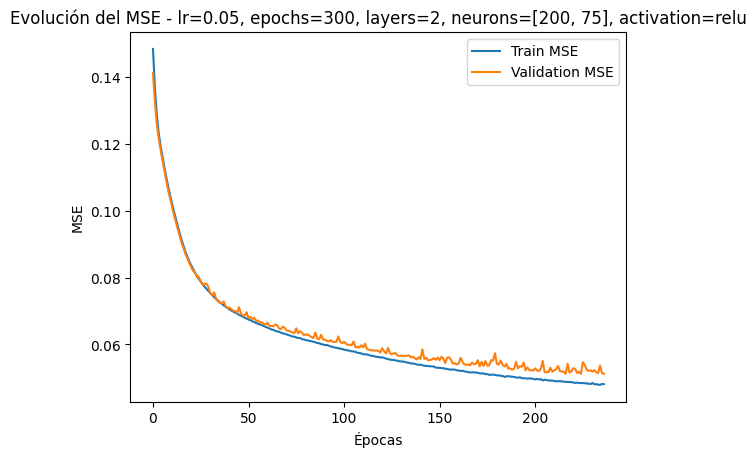

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=sigmoid): 322.45803213119507s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=sigmoid): 7.96e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 7.93e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


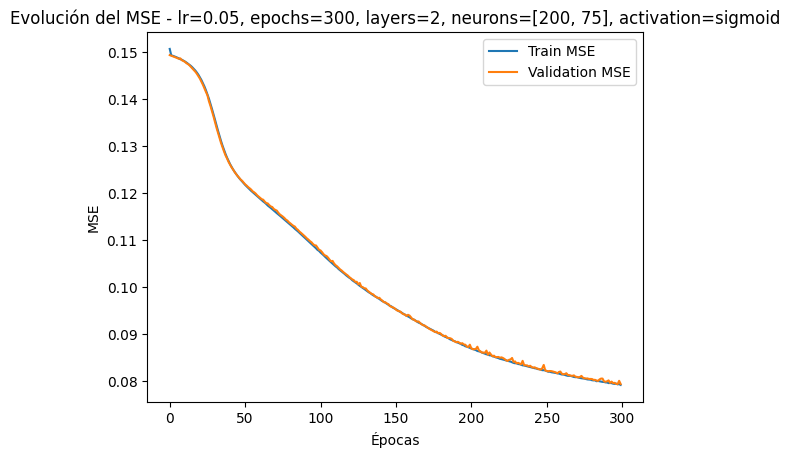

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=softmax): 122.52759313583374s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[200, 75], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 92
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


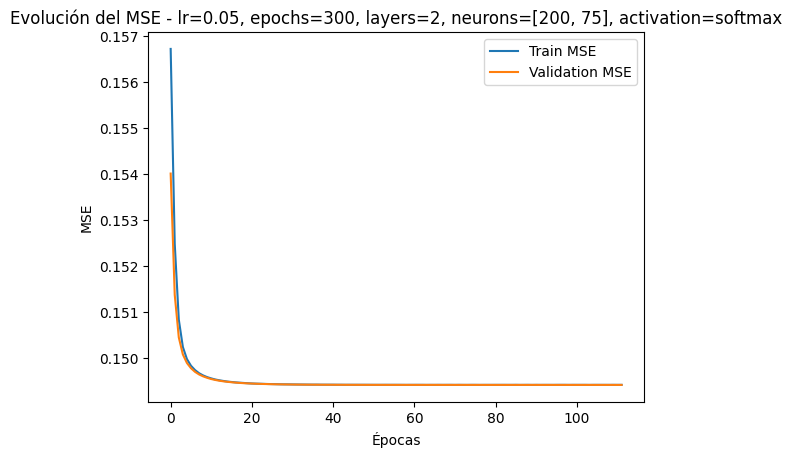

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 269.57210302352905s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 4.87e-02
Época con el menor MSE de validación: 225
MSE de validación mínimo: 4.84e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


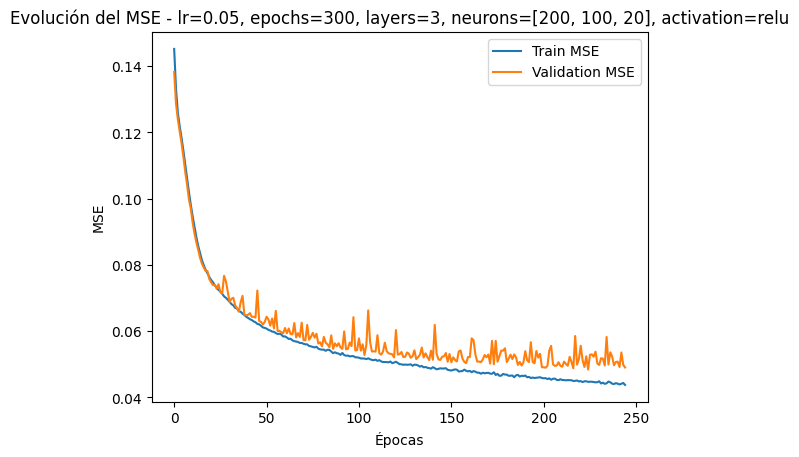

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=sigmoid): 382.47527623176575s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=sigmoid): 9.78e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 9.79e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


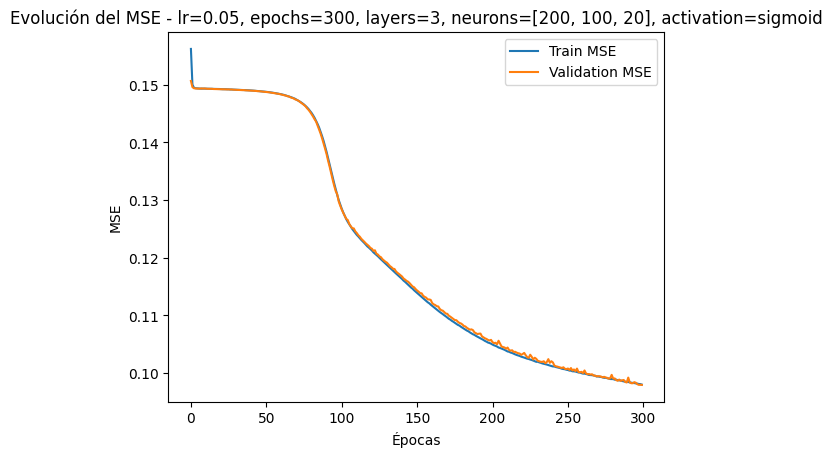

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=softmax): 130.41787719726562s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 95
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


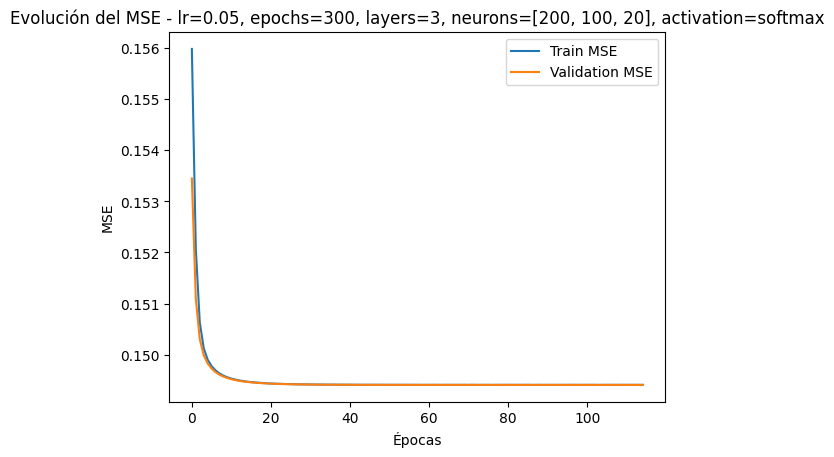

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 296.25326561927795s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=relu): 6.08e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 6.09e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


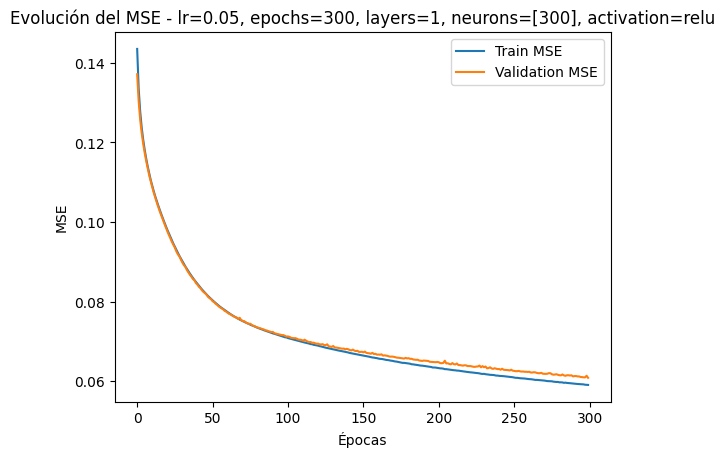

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 322.36667585372925s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=sigmoid): 7.86e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 7.82e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


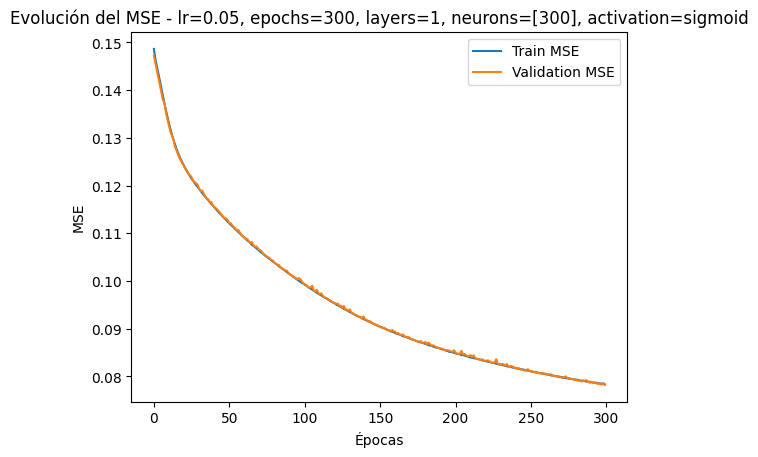

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 323.2111306190491s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=1, num_neurons=[300], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 300
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


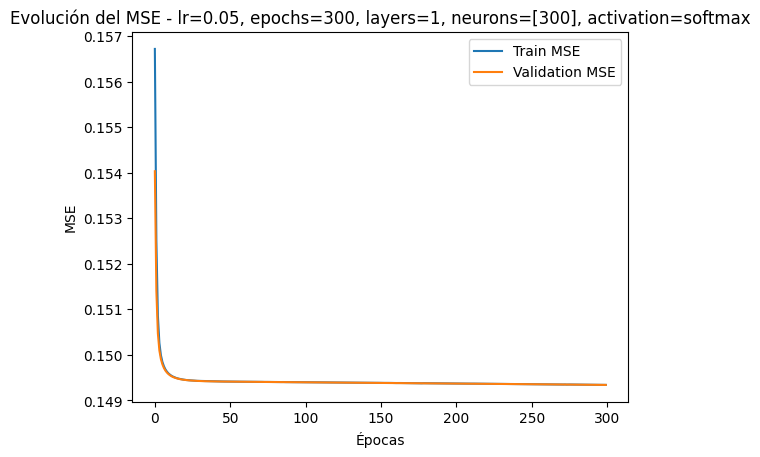

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 382.4664387702942s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=relu): 4.96e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 4.96e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


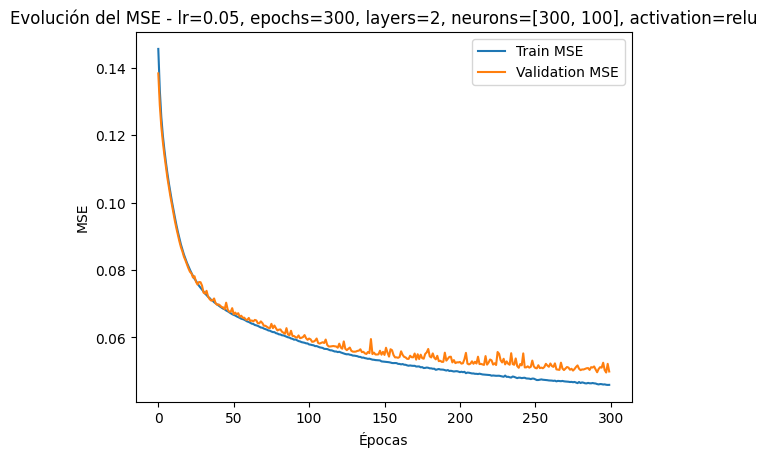

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 382.46279430389404s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=sigmoid): 7.93e-02
Época con el menor MSE de validación: 298
MSE de validación mínimo: 7.90e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


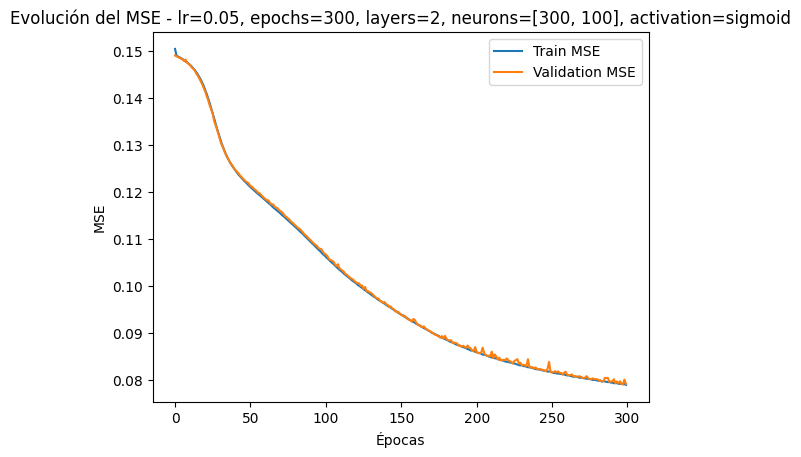

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 138.26234793663025s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=2, num_neurons=[300, 100], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 100
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


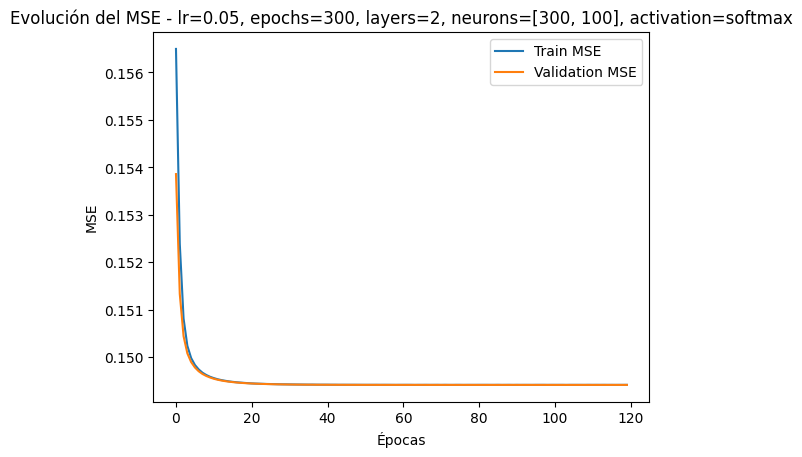

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 314.1756241321564s
304/304 [==============================] - 1s 3ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.73e-02
Época con el menor MSE de validación: 225
MSE de validación mínimo: 4.72e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


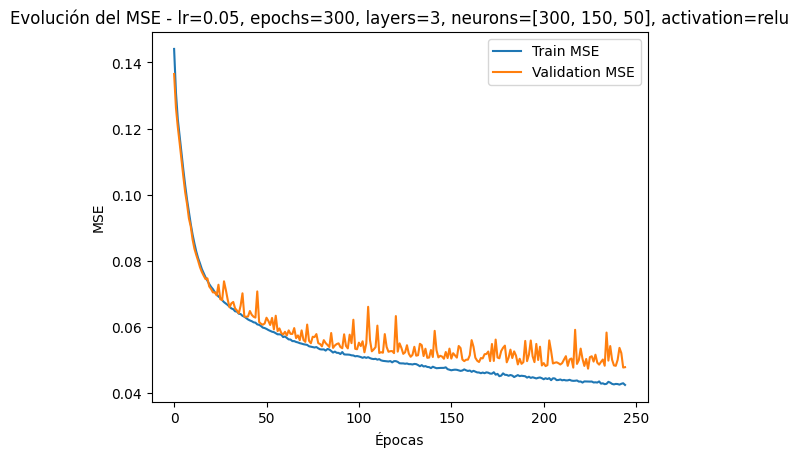

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 442.75331449508667s
304/304 [==============================] - 1s 3ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=sigmoid): 8.91e-02
Época con el menor MSE de validación: 300
MSE de validación mínimo: 8.84e-02 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


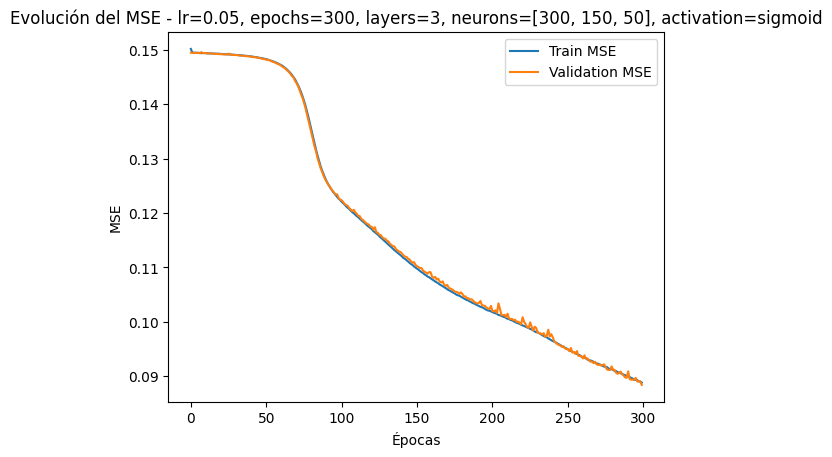

Tiempo de entrenamiento para (lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 134.51833939552307s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.05, epoch = 300, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=softmax): 1.49e-01
Época con el menor MSE de validación: 80
MSE de validación mínimo: 1.49e-01 



<ipython-input-14-7564741297d2>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


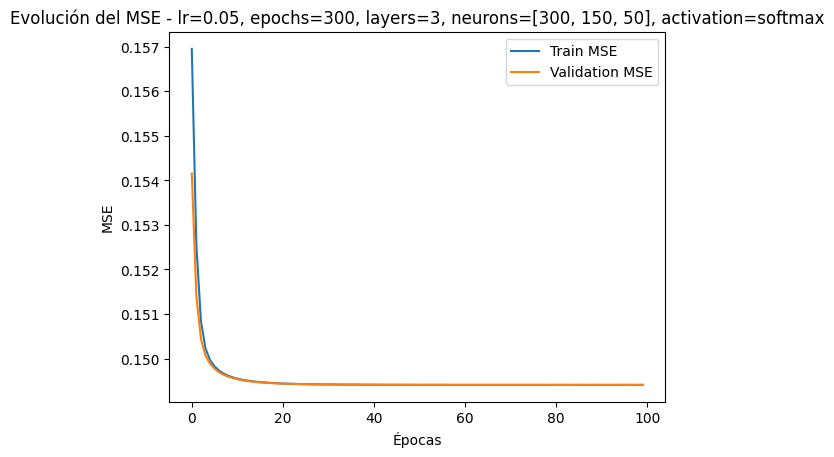

In [14]:
# Definir las listas de valores para los hiperparámetros
learning_rates = [0.2, 0.1, 0.05]
hidden_layers_list = [
    {1: [100], 2: [60, 30], 3: [50, 25, 15]},
    {1: [200], 2: [200, 75], 3: [200, 100, 20]},
    {1: [300], 2: [300, 100], 3: [300, 150, 50]}
]
activation_functions = ['relu', 'sigmoid', 'softmax']
epochs_list = [300]

# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['LR', 'Hidden Layers', 'Neurons', 'Activation Function', 'Epochs', 'Best Epoch', 'Tiempo Entrenamiento', 'Train MSE', 'Validation MSE', 'Test MSE'])

# Iterar sobre todas las combinaciones de hiperparámetros
for lr in learning_rates:
    for hidden_layers_dict in hidden_layers_list:
        for num_hidden_layers, num_neurons in hidden_layers_dict.items():
            for activation_function in activation_functions:
                for epochs in epochs_list:

                    start_time = time.time()
                    # Construir y entrenar un modelo con los hiperparámetros actuales
                    modelo, historico = build_and_train_mlp(lr, num_hidden_layers, num_neurons, activation_function, epochs, patience=20)
                    tiempo_total = time.time() - start_time

                    # Obtener las predicciones
                    prediccion = modelo.predict(X_test)
                    # Obtener el MSE de test
                    mse_test = mean_squared_error(y_test, prediccion)
                    print(f"MSE de test ((lr = {lr}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {mse_test:.2e}")

                    # Obtener los errores de entrenamiento y validación
                    mse_train = historico.history['loss']
                    mse_val = historico.history['val_loss']

                    # Encontrar la época en la que el MSE de validación es el menor
                    best_epoch = np.argmin(mse_val) + 1

                    # Obtener el valor mínimo del MSE de entrenamiento
                    min_mse_train = np.min(mse_train)
                    # Obtener el valor mínimo del MSE de validación
                    min_mse_val = np.min(mse_val)

                    print(f"Época con el menor MSE de validación: {best_epoch}")
                    print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

                    # Agregar los resultados al DataFrame
                    resultados_df = resultados_df.append({
                        'LR': lr,
                        'Hidden Layers': num_hidden_layers,
                        'Neurons': num_neurons,
                        'Activation Function': activation_function,
                        'Epochs': epochs,
                        'Best Epoch': best_epoch,
                        'Tiempo Entrenamiento': round(tiempo_total, 3),
                        'Train MSE': round(min_mse_train, 4),
                        'Validation MSE': round(min_mse_val, 4),
                        'Test MSE': round(mse_test, 4)
                    }, ignore_index=True)

                    # Graficar la evolución del MSE durante el entrenamiento
                    plt.plot(mse_train, label='Train MSE')
                    plt.plot(mse_val, label='Validation MSE')
                    plt.title(f'Evolución del MSE - lr={lr}, epochs={epochs}, layers={num_hidden_layers}, neurons={num_neurons}, activation={activation_function}')
                    plt.xlabel('Épocas')
                    plt.ylabel('MSE')
                    plt.legend()
                    plt.show()

# Mostrar el DataFrame
resultados_df.to_csv('pruebas.csv', index=False)


### 6.3 Elección de los 3 mejores modelos y obtencion de metricas especificas para problemas desbalanceados

Elegimos los 3 modelos con menor error de validación.
- RELU, lr = 0.2, neuronas = [300,150,50] --> val_MSE = 4,56E-02
- RELU, lr = 0.2, neuronas = [200,100,20] --> val_MSE = 4,61E-02
- RELU, lr = 0.1, neuronas = [200,100,20] --> val_MSE = 4,73E-02

A continuación, procederemos a reentrenar los modelos, esta vez configurando un número de épocas más elevado (500) y una paciencia ampliada (50), con el objetivo de evitar quedar atrapados en mínimos locales. Además, calcularemos métricas pertinentes para problemas desbalanceados, tales como precisión (precision), sensibilidad (recall) y puntuación F1 (f1-score).

In [15]:
def entrenar_y_obtener_metricas_desbalanceado(lr, num_hidden_layers, num_neurons, activation_function, epochs, patience, resultados_df, balance_classes=False):
    start_time = time.time()
    # Construimos y entrenamos un modelo con los hiperparámetros actuales
    modelo, historico = build_and_train_mlp(lr, num_hidden_layers, num_neurons, activation_function, epochs, patience=patience, balance_classes=balance_classes)
    tiempo_total = time.time() - start_time

    # Obtenemos las predicciones
    prediccion = modelo.predict(X_test)
    # Obtenemos el MSE de test
    mse_test = mean_squared_error(y_test, prediccion)
    print(f"MSE de test ((lr = {lr}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {mse_test:.2e}")

    # Obtenemos los errores de entrenamiento y validación
    mse_train = historico.history['loss']
    mse_val = historico.history['val_loss']

    # Encontramos la época en la que el MSE de validación es el menor
    best_epoch = np.argmin(mse_val) + 1

    # Obtenemos el valor mínimo del MSE de entrenamiento
    min_mse_train = np.min(mse_train)
    # Obtenemos el valor mínimo del MSE de validación
    min_mse_val = np.min(mse_val)

    print(f"Época con el menor MSE de validación: {best_epoch + 1}")  # Sumamos 1 porque las épocas comienzan desde 0
    print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

    # Obtenemos la clase a la que corresponde cada salida (la predicción contiene las probabilidades de pertenecer a cada clase)
    y_pred_classes = np.argmax(prediccion, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Obtenemos las métricas para problemas debsalanceados
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes, average=None) #average=None para que nos saque el valor para clase
    precision = precision_score(y_test_classes, y_pred_classes, average=None) #average=None para que nos saque el valor para clase
    f1 = f1_score(y_test_classes, y_pred_classes, average=None) #average=None para que nos saque el valor para clase

    # Agregamos los resultados a DataFrame
    resultados_df = resultados_df.append({
      'LR': lr,
      'Neurons': num_neurons,
      'Activation Function': activation_function,
      'Epochs': epochs,
      'Best Epoch': best_epoch,
      'Tiempo': round(tiempo_total, 3),
      'Train MSE': round(min_mse_train,4),
      'Validation MSE': round(min_mse_val,4),
      'Test MSE': round(mse_test,4),
      'Accuracy': round(accuracy,3),
      'Recall': np.round(recall,3).tolist(),
      'Precision': np.round(precision,3).tolist(),
      'F1_score': np.round(f1,3).tolist()
    }, ignore_index=True)

    # Graficamos la evolución del MSE durante el entrenamiento
    plt.plot(mse_train, label='Train MSE')
    plt.plot(mse_val, label='Validation MSE')
    plt.title(f'Evolución del MSE - lr={lr}, epochs={epochs}, layers={num_hidden_layers}, neurons={num_neurons}, activation={activation_function}')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    return resultados_df

Tiempo de entrenamiento para (lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 377.23738145828247s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.36e-02
Época con el menor MSE de validación: 226
MSE de validación mínimo: 4.35e-02 



<ipython-input-15-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


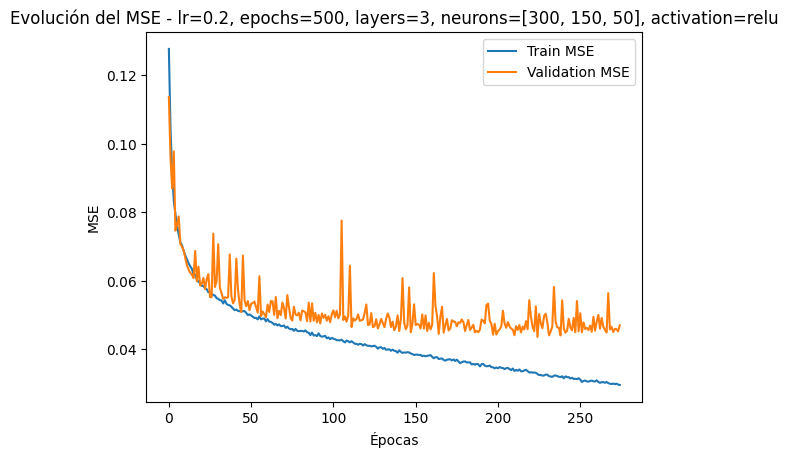

Tiempo de entrenamiento para (lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 347.93340039253235s
304/304 [==============================] - 1s 1ms/step
MSE de test ((lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 4.52e-02
Época con el menor MSE de validación: 259
MSE de validación mínimo: 4.41e-02 



<ipython-input-15-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


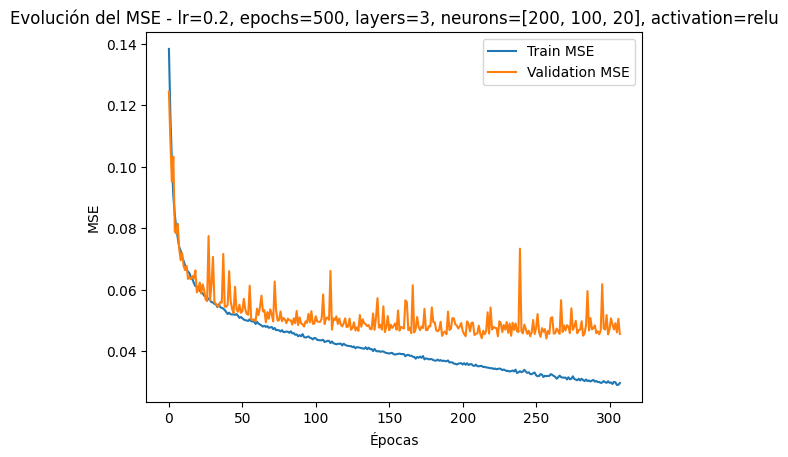

Tiempo de entrenamiento para (lr = 0.1, epoch = 500, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 402.5779857635498s
304/304 [==============================] - 1s 1ms/step
MSE de test ((lr = 0.1, epoch = 500, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 4.46e-02
Época con el menor MSE de validación: 313
MSE de validación mínimo: 4.48e-02 



<ipython-input-15-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


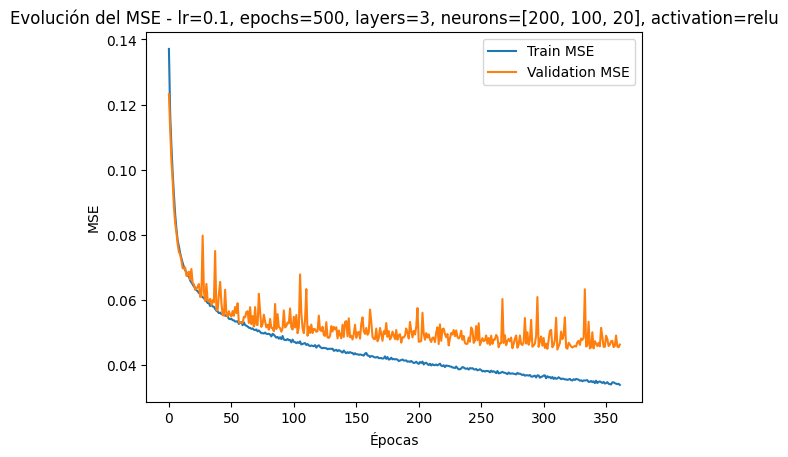

In [17]:
# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['LR', 'Neurons', 'Activation Function', 'Epochs', 'Best Epoch', 'Tiempo', 'Train MSE', 'Validation MSE', 'Test MSE', 'Accuracy', 'Recall', 'Precision', 'F1_score'])

resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.2, num_hidden_layers=3, num_neurons=[300,150,50], activation_function='relu', epochs=500, patience=50, resultados_df=resultados_df)
resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.2, num_hidden_layers=3, num_neurons=[200,100,20], activation_function='relu', epochs=500, patience=50, resultados_df=resultados_df)
resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.1, num_hidden_layers=3, num_neurons=[200,100,20], activation_function='relu', epochs=500, patience=50, resultados_df=resultados_df)

resultados_df.to_csv('mejores_modelos.csv', index=False)

### 6.3 Exploración con balanceo (weights)

Los entrenamos otra vez incluyendo el balanceo de clases. Analizamos la influencia que tiene esta técnica de balanceo.

Tiempo de entrenamiento para (lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 324.0446090698242s
304/304 [==============================] - 1s 1ms/step
MSE de test ((lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[300, 150, 50], activation_function=relu): 4.49e-02
Época con el menor MSE de validación: 189
MSE de validación mínimo: 4.45e-02 



<ipython-input-15-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


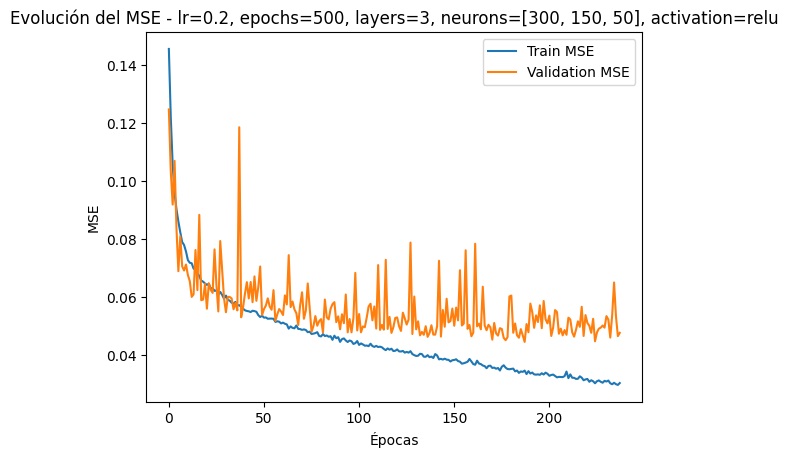

Tiempo de entrenamiento para (lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 319.9838037490845s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.2, epoch = 500, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 4.54e-02
Época con el menor MSE de validación: 226
MSE de validación mínimo: 4.50e-02 



<ipython-input-15-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


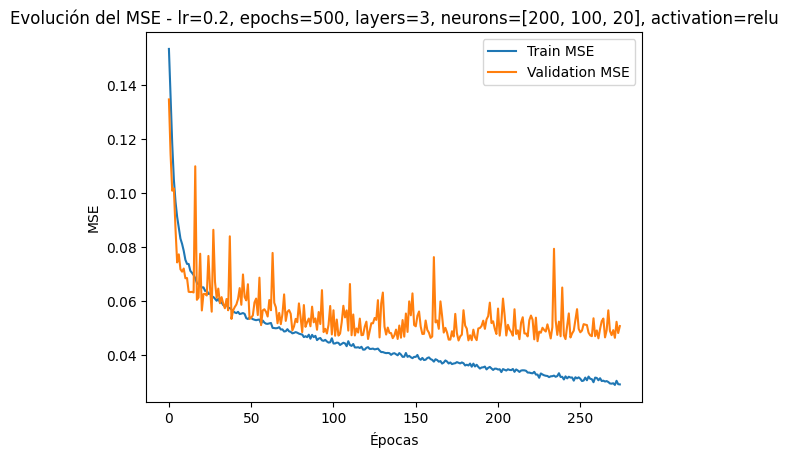

Tiempo de entrenamiento para (lr = 0.1, epoch = 500, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 321.2905316352844s
304/304 [==============================] - 1s 2ms/step
MSE de test ((lr = 0.1, epoch = 500, num_hidden_layers=3, num_neurons=[200, 100, 20], activation_function=relu): 4.68e-02
Época con el menor MSE de validación: 226
MSE de validación mínimo: 4.57e-02 



<ipython-input-15-57a0312949c6>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_df = resultados_df.append({


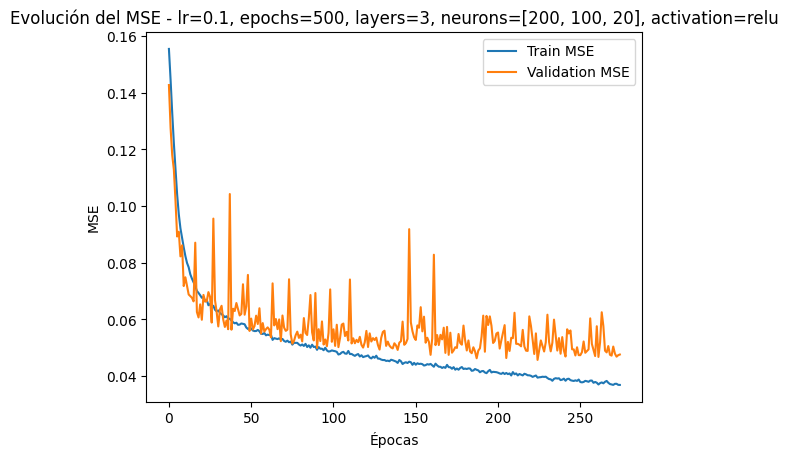

In [19]:
# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['LR', 'Neurons', 'Activation Function', 'Epochs', 'Best Epoch', 'Tiempo', 'Train MSE', 'Validation MSE', 'Test MSE', 'Accuracy', 'Recall', 'Precision', 'F1_score'])

resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.2, num_hidden_layers=3, num_neurons=[300,150,50], activation_function='relu', epochs=500, patience=50, balance_classes=True, resultados_df=resultados_df)
resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.2, num_hidden_layers=3, num_neurons=[200,100,20], activation_function='relu', epochs=500, patience=50, balance_classes=True, resultados_df=resultados_df)
resultados_df = entrenar_y_obtener_metricas_desbalanceado(lr=0.1, num_hidden_layers=3, num_neurons=[200,100,20], activation_function='relu', epochs=500, patience=50, balance_classes=True, resultados_df=resultados_df)

resultados_df.to_csv('balanceo_mejores_modelos.csv', index=False)

### 6.3 Construimos el modelo final
Para la elección del modelo final, no sólo nos fijaremos en el error de validación, sino que tendremos en cuenta las métricas de precisión, recall, accuracy y f1-score sobre el conjunto de validación puesto que estamos ante un problema desbalanceado.

Analizando los resultados obtenidos, podemos observar que son realmente similares. Tanto los modelos con balanceo como sin, son capaces de clasificar correctamente la mayoría de muestras de cada clase. Es decir, todos los modelos nos dan buenos resultados de recall, precision, accuracy y f1-score.

Por esta razón, vamos a escoger el modelo que maximice el f1-score (que relaciona el recall y la precision) y el accuracy.

Este modelo es el siguiente:


*   RELU, lr = 0.2, neuronas = [300,150,50], balance_classes = False

Sorprendentemente, es un modelo que no experimenta un balanceo de clases por medio de la inclusión de pesos.

Lo entrenamos con los datos de validación y train.


Primero, juntamos los datos de train y validation y lo entrenamos con el número de épocas que minimiza el error de validación, 265.

In [20]:
# Combinamos los conjuntos de entrenamiento y validación
X_train_final = np.concatenate((X_train, X_validation), axis=0)
y_train_final = np.concatenate((y_train, y_validation), axis=0)

In [27]:
input_shape=(X_train_final.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla.

# ESPECIFICAR LOS HIPERPARAMETROS CUANDO LOS TENGAMOS
modelo_final = Sequential()

# Capa de entrada
modelo_final.add(Dense(300, activation='relu', input_shape=input_shape))

# Capas ocultas
modelo_final.add(Dense(150, activation='relu'))
modelo_final.add(Dense(50, activation='relu'))

# Capa de salida (5 clases --> 5 neuronas)
modelo_final.add(Dense(5, activation='softmax'))

modelo_final.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0), metrics=['mse'])

start_time = time.time()
# Entrenamos el modelo, incluyendo o no el balanceo de clases según el parámetro
historico = modelo_final.fit(X_train_final, y_train_final, epochs=225, batch_size=32)
tiempo_total = time.time() - start_time
print(f"Tiempo de entrenamiento para (lr = {0.2}, epoch = {225}, num_hidden_layers={3}, num_neurons={[300,150,50]}, activation_function={'relu'}): {tiempo_total}s")

# Guardamos los pesos del modelo
modelo_final.save_weights('pesos.h5')


Epoch 1/225
608/608 [==============================] - 3s 2ms/step - loss: 0.1295 - mse: 0.1295
Epoch 2/225
608/608 [==============================] - 1s 2ms/step - loss: 0.1031 - mse: 0.1031
Epoch 3/225
608/608 [==============================] - 1s 2ms/step - loss: 0.0875 - mse: 0.0875
Epoch 4/225
608/608 [==============================] - 1s 2ms/step - loss: 0.0793 - mse: 0.0793
Epoch 5/225
608/608 [==============================] - 2s 3ms/step - loss: 0.0748 - mse: 0.0748
Epoch 6/225
608/608 [==============================] - 2s 3ms/step - loss: 0.0723 - mse: 0.0723
Epoch 7/225
608/608 [==============================] - 1s 2ms/step - loss: 0.0700 - mse: 0.0700
Epoch 8/225
608/608 [==============================] - 1s 2ms/step - loss: 0.0680 - mse: 0.0680
Epoch 9/225
608/608 [==============================] - 1s 2ms/step - loss: 0.0662 - mse: 0.0662
Epoch 10/225
608/608 [==============================] - 1s 2ms/step - loss: 0.0652 - mse: 0.0652
Epoch 11/225
608/608 [=================

Realizamos las predicciones sobre los datos de test (X_test) y las evaluamos con la variable de respuesta de test (y_test).

In [28]:
# Predecimos sobre el conjunto de prueba
y_pred = modelo_final.predict(X_test)

# Convertimos las predicciones a clases
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Creamos un DataFrame con las clases predichas y las clases reales
resultados_df = pd.DataFrame({'Clase Predicha': y_pred_classes, 'Clase Real': y_test_classes})

# Ordenamos los valores reales de menor a mayor
resultados_df = resultados_df.sort_values(by='Clase Real')

# Guardamos el DataFrame como un archivo de texto
resultados_df.to_csv('predicciones_y_deseados.txt', index=False, sep='\t')

# Calculamos y mostrar las métricas
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average=None)
recall = recall_score(y_test_classes, y_pred_classes, average=None)
f1 = f1_score(y_test_classes, y_pred_classes, average=None)
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

print(f'Accuracy: {accuracy:.3f}')
print("\n")
print(f'Precision: {np.round(precision,3).tolist()}')
print("\n")
print(f'Recall: {np.round(recall,3).tolist()}')
print("\n")
print(f'F1 Score: {np.round(f1,3).tolist()}')
print("\n")
print('Confusion Matrix:')
print(conf_matrix)


304/304 [==============================] - 1s 2ms/step
Accuracy: 0.841


Precision: [0.817, 0.864, 0.915, 0.793, 0.846]


Recall: [0.954, 0.771, 0.75, 0.82, 0.753]


F1 Score: [0.88, 0.815, 0.824, 0.806, 0.797]


Confusion Matrix:
[[3465  141   14    7    6]
 [ 397 1424    5   14    7]
 [ 212   36 1639  254   45]
 [ 136   36   70 1204   22]
 [  29   12   64   39  439]]


Comparamos las predicciones con los valores reales gráficamente.

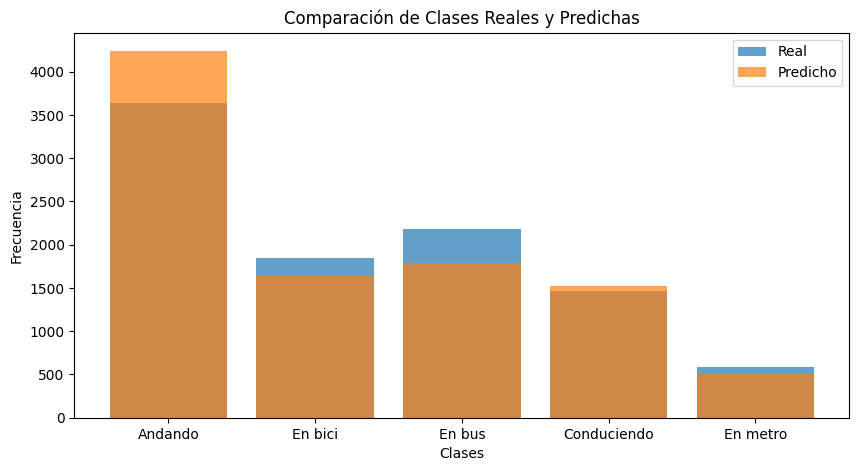

In [29]:
# Definir etiquetas de clases
class_labels = ['Andando', 'En bici', 'En bus', 'Conduciendo', 'En metro']

# Crear un gráfico de barras para las clases reales
plt.figure(figsize=(10, 5))
plt.bar(class_labels, np.bincount(y_test_classes), label='Real', alpha=0.7)

# Crear un gráfico de barras para las clases predichas
plt.bar(class_labels, np.bincount(y_pred_classes), label='Predicho', alpha=0.7)

plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.title('Comparación de Clases Reales y Predichas')
plt.legend()
plt.show()